In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import astropy
from tqdm.notebook import trange, tqdm
import scipy as sp
from astropy.io import ascii
import emcee
import corner
import matplotlib.gridspec as gridspec
plt.style.use('tableau-colorblind10')

### Load relevant sensitivity grids

In [2]:
projSepGrid = np.load('data/projSepGrid.npy')
qGrid = np.load('data/qGrid.npy')

totSensQATMO0p9 = np.load('data/totSensQATMO0p9.npy')
totSensMalmQATMO0p9 = np.load('data/totSensMalmQATMO0p9.npy')
bigSensCgridATMO0p9 = np.load('data/bigSensCgrid0p9.npy')

totSensQATMO1p2 = np.load('data/totSensQATMO1p2.npy')
totSensMalmQATMO1p2 = np.load('data/totSensMalmQATMO1p2.npy')
bigSensCgridATMO1p2 = np.load('data/bigSensCgrid1p2.npy')

totSensQATMO1p5 = np.load('data/totSensQATMO1p5.npy')
totSensMalmQATMO1p5 = np.load('data/totSensMalmQATMO1p5.npy')
bigSensCgridATMO1p5 = np.load('data/bigSensCgrid1p5.npy')

totSensQATMO1p9 = np.load('data/totSensQATMO1p9.npy')
totSensMalmQATMO1p9 = np.load('data/totSensMalmQATMO1p9.npy')
bigSensCgridATMO1p9 = np.load('data/bigSensCgrid1p9.npy')

totSensQATMO2p4 = np.load('data/totSensQATMO2p4.npy')
totSensMalmQATMO2p4 = np.load('data/totSensMalmQATMO2p4.npy')
bigSensCgridATMO2p4 = np.load('data/bigSensCgrid2p4.npy')

totSensQATMO3p1 = np.load('data/totSensQATMO3p1.npy')
totSensMalmQATMO3p1 = np.load('data/totSensMalmQATMO3p1.npy')
bigSensCgridATMO3p1 = np.load('data/bigSensCgrid3p1.npy')

print(np.shape(projSepGrid),np.shape(qGrid),np.shape(totSensMalmQATMO1p5))

psgg,qgg = np.meshgrid(projSepGrid,qGrid)#,indexing='ij')
print(np.shape(psgg),np.shape(qgg))
lg10psgg = np.log10(psgg)
maxpsgrid = np.max(projSepGrid)
maxpsgriddelta = projSepGrid[-1]-projSepGrid[-2]

(1000,) (1001,) (1001, 1000)
(1001, 1000) (1001, 1000)


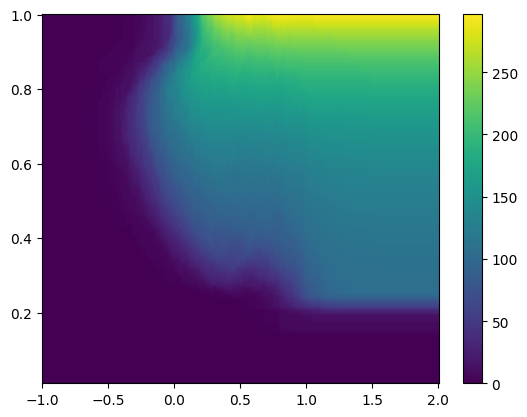

In [3]:
cax = plt.pcolormesh(np.log10(projSepGrid),qGrid,totSensMalmQATMO0p9)
#plt.xscale('log')
plt.colorbar(cax)

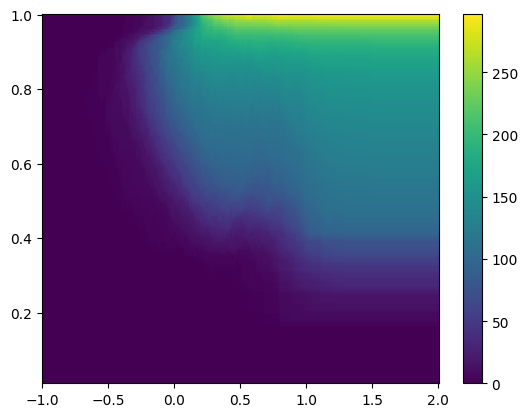

In [4]:
cax = plt.pcolormesh(np.log10(projSepGrid),qGrid,totSensMalmQATMO3p1)
#plt.xscale('log')
plt.colorbar(cax)

In [5]:
detTable = ascii.read('data/detectionsTabMass.csv')
print(detTable.colnames)
#get rid of marginal detection
detTable['c0_weightedMean'][np.where(detTable['source'] == '2M 2028+0052')] = np.nan
detTable['projSep'][np.where(detTable['source'] == '2M 2028+0052')] = np.nan

['target', 'source', 'sep_weightedMean', 'pa_weightedMean', 'c0_weightedMean', 'c1_weightedMean', 'ssep_weightedMean', 'spa_weightedMean', 'sc0_weightedMean', 'sc1_weightedMean', 'ssep_medianErr', 'spa_medianErr', 'sc0_medianErr', 'sc1_medianErr', 'sysstd_sep', 'sysstd_pa', 'sysstd_c0', 'sysstd_c1', 'sysrms_sep', 'sysrms_pa', 'sysrms_c0', 'sysrms_c1', 'ncal', 'cals', 'pa_weightedMean_degrees', 'spa_weightedMean_degrees', 'spa_medianErr_degrees', 'sysstd_pa_degrees', 'sysrms_pa_degrees', 'dist', 'sdist', 'sep', 'ssep', 'projSep', 'sprojSep', '2MASSphotFlag110', '2MASSphotFlag170', 'm110', 'm170', 'sm110', 'sm170', 'M110', 'M170', 'sM110', 'sM170', 'logLA', 'logLB', 'slogLA', 'slogLB', 'qATMO0p9', 'maATMO0p9', 'mbATMO0p9', 'sqATMO0p9', 'smaATMO0p9', 'smbATMO0p9', 'qATMO1p2', 'maATMO1p2', 'mbATMO1p2', 'sqATMO1p2', 'smaATMO1p2', 'smbATMO1p2', 'qATMO1p5', 'maATMO1p5', 'mbATMO1p5', 'sqATMO1p5', 'smaATMO1p5', 'smbATMO1p5', 'qATMO1p9', 'maATMO1p9', 'mbATMO1p9', 'sqATMO1p9', 'smaATMO1p9', 'smbA

In [6]:
detTable.show_in_notebook()

idx,target,source,sep_weightedMean,pa_weightedMean,c0_weightedMean,c1_weightedMean,ssep_weightedMean,spa_weightedMean,sc0_weightedMean,sc1_weightedMean,ssep_medianErr,spa_medianErr,sc0_medianErr,sc1_medianErr,sysstd_sep,sysstd_pa,sysstd_c0,sysstd_c1,sysrms_sep,sysrms_pa,sysrms_c0,sysrms_c1,ncal,cals,pa_weightedMean_degrees,spa_weightedMean_degrees,spa_medianErr_degrees,sysstd_pa_degrees,sysrms_pa_degrees,dist,sdist,sep,ssep,projSep,sprojSep,2MASSphotFlag110,2MASSphotFlag170,m110,m170,sm110,sm170,M110,M170,sM110,sM170,logLA,logLB,slogLA,slogLB,qATMO0p9,maATMO0p9,mbATMO0p9,sqATMO0p9,smaATMO0p9,smbATMO0p9,qATMO1p2,maATMO1p2,mbATMO1p2,sqATMO1p2,smaATMO1p2,smbATMO1p2,qATMO1p5,maATMO1p5,mbATMO1p5,sqATMO1p5,smaATMO1p5,smbATMO1p5,qATMO1p9,maATMO1p9,mbATMO1p9,sqATMO1p9,smaATMO1p9,smbATMO1p9,qATMO2p4,maATMO2p4,mbATMO2p4,sqATMO2p4,smaATMO2p4,smbATMO2p4,qATMO3p1,maATMO3p1,mbATMO3p1,sqATMO3p1,smaATMO3p1,smbATMO3p1
0,data/10143/U20004/,2M 0004-4044,0.08319088112,0.7738399121,1.125983905,nan,0.000224630421,0.004544961219,0.008034902292,nan,0.00049,0.0099,0.018,nan,0.0001180847154,0.007259090852,0.003709447398,nan,0.0001190186863,0.007327634287,0.003715736393,nan,5,"2M 1539-0520, 2M 2148+4003, 2M 0727+1710, 2M 0355+1133, 2M 0243-2453",44.33776098,0.2604070959,0.5672282172,0.4159152689,0.4198425184,12.129407,0.03487500000000043,0.08319088112,0.00049,1.0090560557930959,0.006613739696618808,0.0,0.0,13.79627412,12.09627412,0.05,0.05,13.377076275157274,11.677076275157274,0.05038830662248215,0.05038830662248215,-4.164318236344465,-4.20826018834633,0.017564757535337674,0.017680056055003238,0.9703519851293873,61.22758939422344,59.412312913371736,0.01648843874644669,0.7052712625344382,0.7421828497036267,0.9767341423250858,66.09228892170898,64.5545951342472,0.01304376948493922,0.613970488237856,0.6193386750607386,0.9818842231068292,70.07737264780727,68.80786659966,0.010122898946204046,0.4944891797569054,0.5171926662113419,0.9865761452472611,72.85786049250365,71.87982715565697,0.007538143788212292,0.38352766953367423,0.398075487797438,0.989983589567038,74.66547317062124,73.91759314617299,0.005652816627871942,0.29012351229798367,0.30927233310076524,0.9922049062049951,75.82600374373126,75.23493293244849,0.004433052934884632,0.23317873018510984,0.24384957049782743
1,data/10143/U13016/,2M 0025+4759,0.3345483896,4.063003412,1.352909943,1.250589047,0.0003984896868,0.001016890005,0.01474991177,0.01019159261,0.00088,0.0022,0.033,0.023,4.96e-05,8.94e-05,0.002993325909,0.001019803903,4.97e-05,8.95e-05,0.002995344288,0.001019862724,5,"2M 2139+0220, 2M 0243-2453, 2M 2351-2537, 2M 0228+1639, 2M 0825+2115",232.7929477,0.05826350551,0.1260507149,0.005124690313,0.005128418739,53.99568034557235,0.40817468943737206,0.3345483896,0.00088,18.0641679049676,0.1445850427520376,0.0,0.0,15.55910117,13.55103254,0.05,0.05,11.897306081729578,9.889237451729578,0.05262559095137935,0.05262559095137935,-3.532092508015108,-3.6374825051018065,0.014031834229722854,0.01422395840766295,0.9589043577231203,82.78318148544332,79.38115347257553,0.007659581297113916,0.45405666785960636,0.46096929218415605,0.9655442727034423,84.15898774408326,81.25922861281879,0.006434783097645716,0.38729607692082874,0.3917027876936392,0.9727006440368412,84.41691049741182,82.11238320843286,0.005103150366190366,0.3065325654775151,0.31093389224035056,0.9778650726711837,84.33501508263218,82.46826565250349,0.00415119234843004,0.248148967710535,0.25235209793183144,0.9810833237995967,84.25199961200403,82.65823181610725,0.003545652451848548,0.21174993981079965,0.21466460809821308,0.9838022545185098,83.94518515275416,82.58546240925328,0.003044606407729181,0.18078588016964997,0.18354250419683835
2,data/10143/U20081/,2M 0147-4954,0.1388452706,1.267824019,2.345447425,2.021867815,0.0002034058838,0.001234309144,0.01497855851,0.00757256289,0.00042,0.0025,0.03,0.016,0.0008553034549,0.003391164992,0.2198994316,0.08075989104,0.0008557858256,0.003439731716,0.2204988409,0.08163661576,5,"2M 1058-1548, 2M 1421+1827, 2M 0123-4240, 2M 0

In [7]:
qsATMO0p9 = []
sepsATMO0p9 = []

qsATMO1p2 = []
sepsATMO1p2 = []

qsATMO1p5 = []
sepsATMO1p5 = []

qsATMO1p9 = []
sepsATMO1p9 = []

qsATMO2p4 = []
sepsATMO2p4 = []

qsATMO3p1 = []
sepsATMO3p1 = []

detContsAvg = []
detContsMin = []
detContsJ = []

for line in detTable:
#for target in c0goodDet:
    #results = binResultsTab[np.where(np.bitwise_and(binResultsTab['target']==target, np.array(binResultsTab['detectionC0'])))]
    if not np.isnan(line['projSep']):
        
        detContsAvg += [np.nanmean([line['c0_weightedMean'],line['c1_weightedMean']])]
        detContsMin += [np.nanmin([line['c0_weightedMean'],line['c1_weightedMean']])]
        detContsJ += [line['c0_weightedMean'] if ~np.isnan(line['c0_weightedMean']) else line['c1_weightedMean']]

        qsATMO0p9 += [line['qATMO0p9']]
        sepsATMO0p9 += [line['projSep']]
        
        qsATMO1p2 += [line['qATMO1p2']]
        sepsATMO1p2 += [line['projSep']]
        
        qsATMO1p5 += [line['qATMO1p5']]
        sepsATMO1p5 += [line['projSep']]
        
        qsATMO1p9 += [line['qATMO1p9']]
        sepsATMO1p9 += [line['projSep']]
        
        qsATMO2p4 += [line['qATMO2p4']]
        sepsATMO2p4 += [line['projSep']]

        qsATMO3p1 += [line['qATMO3p1']]
        sepsATMO3p1 += [line['projSep']]
        
        print(line['source'])

#for target in c1goodDet:
    #results = binResultsTab[np.where(np.bitwise_and(binResultsTab['target']==target, np.array(binResultsTab['detectionC1'])))]
    #c1qs += [np.average(results['q170'],weights=1./(results['sq170']**2.))]
    #c1seps += [np.average(results['projSep'],weights=1./(results['sprojSep']**2.))]

2M 0004-4044
2M 0025+4759
2M 0147-4954
2M 0423-0414
2M 0429-3123
2M 0700+3157
2M 0915+0422
2M 0926+5847
2M 1021-0304
2M 1553+1532
2M 1707-0558
2M 2152+0937
2M 2252-1730
2M 2255-5713
2M 2351-2537


In [8]:
######## make detection grid
nps = 175
nqs = 50

minps = np.logspace(-4,3,nps,endpoint=0)
minlogps = np.log10(minps)
dlps = minlogps[1]-minlogps[0]
logps = minlogps + dlps/2.
ps = np.power(10.,logps)

maxqs = np.linspace(1.,0.,nqs,endpoint=0)[::-1]
dqs = maxqs[1]-maxqs[0]
qs = maxqs - dqs/2.

print(dlps,dqs)

lpps,qqs = np.meshgrid(logps,qs)#,indexing='ij')

print(np.shape(lpps),np.shape(qqs))

0.040000000000000036 0.020000000000000018
(50, 175) (50, 175)


In [9]:
detsATMO0p9 = np.zeros((nqs,nps))
contsATMO0p9 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO0p9,sepsATMO0p9,detContsJ):
    detsATMO0p9[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO0p9[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)

detsATMO1p2 = np.zeros((nqs,nps))
contsATMO1p2 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO1p2,sepsATMO1p2,detContsJ):
    detsATMO1p2[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO1p2[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)

detsATMO1p5 = np.zeros((nqs,nps))
contsATMO1p5 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO1p5,sepsATMO1p5,detContsJ):
    detsATMO1p5[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO1p5[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)
    
detsATMO1p9 = np.zeros((nqs,nps))
contsATMO1p9 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO1p9,sepsATMO1p9,detContsJ):
    detsATMO1p9[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO1p9[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)

detsATMO2p4 = np.zeros((nqs,nps))
contsATMO2p4 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO2p4,sepsATMO2p4,detContsJ):
    detsATMO2p4[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO2p4[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)
    
detsATMO3p1 = np.zeros((nqs,nps))
contsATMO3p1 = np.zeros((nqs,nps))

for q,p,c in zip(qsATMO3p1,sepsATMO3p1,detContsJ):
    detsATMO3p1[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += 1
    contsATMO3p1[np.where(np.min(np.abs(qs-q))==np.abs(qs-q)),np.where(np.min(np.abs(ps-p))==np.abs(ps-p))] += (1.+1./c)**(-3./2.)

    
#sensc0intp = sp.interpolate.interp2d(projSepGrid,qGrid,totSensQ110)(qs,ps)
#sensc1intp = sp.interpolate.interp2d(projSepGrid,qGrid,totSensQ170)(qs,ps)

### Malmquist bias correction as function of contrast

In [10]:
malmCorFullResATMO0p9 = np.mean((1.+(1./bigSensCgridATMO0p9))**1.5,axis=0)
malmCorFullResATMO1p2 = np.mean((1.+(1./bigSensCgridATMO1p2))**1.5,axis=0)
malmCorFullResATMO1p5 = np.mean((1.+(1./bigSensCgridATMO1p5))**1.5,axis=0)
malmCorFullResATMO1p9 = np.mean((1.+(1./bigSensCgridATMO1p9))**1.5,axis=0)
malmCorFullResATMO2p4 = np.mean((1.+(1./bigSensCgridATMO2p4))**1.5,axis=0)
malmCorFullResATMO3p1 = np.mean((1.+(1./bigSensCgridATMO3p1))**1.5,axis=0)

In [11]:
# bin down full res sensitivity grid 
######## Takes a long time
sensATMO0p9 = np.zeros((nqs,nps))
sensATMO1p2 = np.zeros((nqs,nps))
sensATMO1p5 = np.zeros((nqs,nps))
sensATMO1p9 = np.zeros((nqs,nps))
sensATMO2p4 = np.zeros((nqs,nps))
sensATMO3p1 = np.zeros((nqs,nps))

sensATMO0p9Malm = np.zeros((nqs,nps))
sensATMO1p2Malm = np.zeros((nqs,nps))
sensATMO1p5Malm = np.zeros((nqs,nps))
sensATMO1p9Malm = np.zeros((nqs,nps))
sensATMO2p4Malm = np.zeros((nqs,nps))
sensATMO3p1Malm = np.zeros((nqs,nps))

for i,p in enumerate(tqdm(minlogps)):
    if p>=np.log10(maxpsgrid):
        p = np.log10(maxpsgrid-maxpsgriddelta)
        print('edge case')
    for j,q in enumerate(maxqs):
        ids = np.where((p < lg10psgg)&(lg10psgg < p+dlps) & (q-dqs < qgg)&(qgg < q))

        senssATMO0p9 = totSensQATMO0p9[ids]
        sensATMO0p9[j,i] = np.median(senssATMO0p9)
        
        senssATMO1p2 = totSensQATMO1p2[ids]
        sensATMO1p2[j,i] = np.median(senssATMO1p2)
        
        senssATMO1p5 = totSensQATMO1p5[ids]
        sensATMO1p5[j,i] = np.median(senssATMO1p5)
        
        senssATMO1p9 = totSensQATMO1p9[ids]
        sensATMO1p9[j,i] = np.median(senssATMO1p9)
        
        senssATMO2p4 = totSensQATMO2p4[ids]
        sensATMO2p4[j,i] = np.median(senssATMO2p4)
        
        senssATMO3p1 = totSensQATMO3p1[ids]
        sensATMO3p1[j,i] = np.median(senssATMO3p1)


        
        senssATMO0p9Malm = totSensMalmQATMO0p9[ids]
        sensATMO0p9Malm[j,i] = np.median(senssATMO0p9Malm)
        
        senssATMO1p2Malm = totSensMalmQATMO1p2[ids]
        sensATMO1p2Malm[j,i] = np.median(senssATMO1p2Malm)
        
        senssATMO1p5Malm = totSensMalmQATMO1p5[ids]
        sensATMO1p5Malm[j,i] = np.median(senssATMO1p5Malm)
        
        senssATMO1p9Malm = totSensMalmQATMO1p9[ids]
        sensATMO1p9Malm[j,i] = np.median(senssATMO1p9Malm)
        
        senssATMO2p4Malm = totSensMalmQATMO2p4[ids]
        sensATMO2p4Malm[j,i] = np.median(senssATMO2p4Malm)
        
        senssATMO3p1Malm = totSensMalmQATMO3p1[ids]
        sensATMO3p1Malm[j,i] = np.median(senssATMO3p1Malm)

sensATMO0p9[np.where(np.isnan(sensATMO0p9))] = 0.
sensATMO1p2[np.where(np.isnan(sensATMO1p2))] = 0.
sensATMO1p5[np.where(np.isnan(sensATMO1p5))] = 0.
sensATMO1p9[np.where(np.isnan(sensATMO1p9))] = 0.
sensATMO2p4[np.where(np.isnan(sensATMO2p4))] = 0.
sensATMO3p1[np.where(np.isnan(sensATMO3p1))] = 0.

sensATMO0p9Malm[np.where(np.isnan(sensATMO0p9Malm))] = 0.
sensATMO1p2Malm[np.where(np.isnan(sensATMO1p2Malm))] = 0.
sensATMO1p5Malm[np.where(np.isnan(sensATMO1p5Malm))] = 0.
sensATMO1p9Malm[np.where(np.isnan(sensATMO1p9Malm))] = 0.
sensATMO2p4Malm[np.where(np.isnan(sensATMO2p4Malm))] = 0.
sensATMO3p1Malm[np.where(np.isnan(sensATMO3p1Malm))] = 0.

  0%|          | 0/175 [00:00<?, ?it/s]

/Users/sfactor/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sfactor/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case
edge case


In [12]:
malmCorATMO0p9 = np.zeros((nqs))
malmCorATMO1p2 = np.zeros((nqs))
malmCorATMO1p5 = np.zeros((nqs))
malmCorATMO1p9 = np.zeros((nqs))
malmCorATMO2p4 = np.zeros((nqs))
malmCorATMO3p1 = np.zeros((nqs))

for j,q in enumerate(maxqs):
    ids = np.where((q-dqs<qGrid) & (qGrid<q))
    
    tempCor = malmCorFullResATMO0p9[ids]
    malmCorATMO0p9[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO1p2[ids]
    malmCorATMO1p2[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO1p5[ids]
    malmCorATMO1p5[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO1p9[ids]
    malmCorATMO1p9[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO2p4[ids]
    malmCorATMO2p4[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO3p1[ids]
    malmCorATMO3p1[j] = np.median(tempCor)


In [13]:
print(np.shape(sensATMO1p5Malm),np.shape(psgg))

(50, 175) (1001, 1000)


In [14]:
#detsATMO      sensATMO       : All
#dets9833ATMO  sens9833ATMO  T: T Dwarfs
#detsOtherATMO sensOtherATMO L: Late M and L

malfFlag = True

dets = detsATMO0p9
sens = sensATMO0p9Malm
malmCor = malmCorATMO0p9
ageStr = '0p9'
sampStr = 'Malm'
sens = sensATMO0p9
sampStr = ''

dets = detsATMO1p2
sens = sensATMO1p2Malm
malmCor = malmCorATMO1p2
ageStr = '1p2'
sampStr = 'Malm'
sens = sensATMO1p2
sampStr = ''

dets = detsATMO1p5
sens = sensATMO1p5Malm
malmCor = malmCorATMO1p5
ageStr = '1p5'
sampStr = 'Malm'
sens = sensATMO1p5
sampStr = ''

dets = detsATMO1p9
sens = sensATMO1p9Malm
malmCor = malmCorATMO1p9
ageStr = '1p9'
sampStr = 'Malm'
sens = sensATMO1p9
sampStr = ''

dets = detsATMO2p4
sens = sensATMO2p4Malm
malmCor = malmCorATMO2p4
ageStr = '2p4'
sampStr = 'Malm'
sens = sensATMO2p4
sampStr = ''

dets = detsATMO3p1
sens = sensATMO3p1Malm
malmCor = malmCorATMO3p1
ageStr = '3p1'
sampStr = 'Malm'
sens = sensATMO3p1
sampStr = ''


gdets = np.copy(dets)
gdets[:,127] = np.zeros(50) 

# [:,np.where(~(np.isclose(logps,13.48) | np.isclose(logps,11.88)))]
print(sum(sum(dets)))

15.0


/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/2109492135.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "C0." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(logps[np.where(gdets)[1]],qs[np.where(gdets)[0]],'C0.',marker='.')
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/2109492135.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "C0." (-> marker='.'). The keyword argument will take precedence.
  plt.plot([logps[127],logps[127]],qs[np.where(dets[:,127])[0]],'C0.',marker='.',fillstyle='none')#facecolors='none',edgecolors='C0')
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/2109492135.py:17: RuntimeWarning: divide by zero encountered in log10
  axup = ax.secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/2109492135.py:17: R

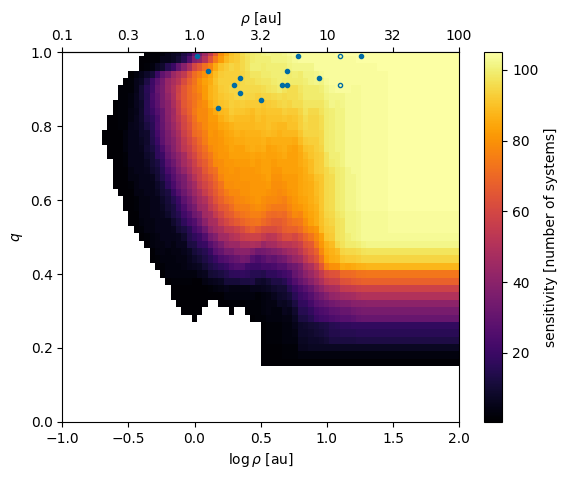

In [15]:
pltsens = np.copy(sens)
pltsens[np.where(pltsens==0)] = np.nan
fig,ax = plt.subplots()
cax = plt.pcolormesh(minlogps,maxqs,pltsens,cmap='inferno',linewidth=0,rasterized=True)
plt.colorbar(cax,label = "sensitivity [number of systems]")
plt.plot(logps[np.where(gdets)[1]],qs[np.where(gdets)[0]],'C0.',marker='.')
plt.plot([logps[127],logps[127]],qs[np.where(dets[:,127])[0]],'C0.',marker='.',fillstyle='none')#facecolors='none',edgecolors='C0')
# cax2=plt.scatter(np.append(logps[np.where(dets)[1]],[-2,-2]),np.append(qs[np.where(dets)[0]],[0,0]),marker='.',c=np.append(dets[np.where(dets)],[0.,1.]),cmap='Blues')
# plt.colorbar(cax2,label='malmquist weighted detections')
plt.ylim(0,1)
# (x_l,x_u) = plt.gca().get_xlim()
# plt.xlim(-1.,x_u)
plt.xlim(-1.,2.)
plt.ylabel(r"$q$")
plt.xlabel(r"$\log\rho~[\mathrm{au}]$")

axup = ax.secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
axup.set_xlabel(r"$\rho$ [au]")
axup.set_xticks(np.logspace(-1,2,7))
#axup.set_xticks([0.1,0.3,0.7,1,3,7,10,30,70,100])
axup.set_xticklabels(['0.1','0.3','1.0','3.2','10','32','100'])

#plt.plot(logps[np.where(sens==0)[1]],qs[np.where(sens==0)[0]],'C1.')
plt.savefig('figs/'+sampStr+ageStr+'GyrSens.pdf',bbox_inches = 'tight')

(75.0, 150.0)

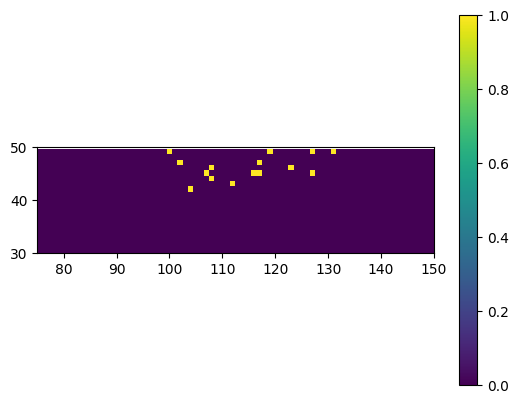

In [16]:
# cax = plt.pcolormesh(minlogps,maxqs,dets,cmap = 'inferno')
# plt.colorbar(cax)
# plt.ylim(0.5,1)
# (x_l,x_u) = plt.gca().get_xlim()
# plt.xlim(-1.,x_u)
cax=plt.imshow(dets)
plt.colorbar(cax)
plt.ylim(30,50)
plt.xlim(75,150)

In [17]:
print(np.max(dets),np.max(sens))

1.0 105.0


### Model params:

`p = [F, g, mlp, slp]`

`F`: $F$ companion frequency

`g`: $\gamma$ power-law mass ratio distribution exponent

`mlp`: $\overline{\log(\rho)}$ log-normal separation distribution mean

`slp`: $\sigma_{\overline{\log(\rho)}}$ log-normal separation distribution standard deviation

In [18]:
# #Prior ranges
# Fran = [0.,2.5]
# gran = [-2.,20.]
# mlpran = [-1.,2.]
# slpran = [0.,2.]
# cornerString = ''

#Wide rho prior
Fran = [0.,2.5]
gran = [-1,35.]
mlpran = [-4.,3.]
slpran = [0.,4.]
cornerString = 'Wide'

In [19]:
def lnPrior(p):
    F, g, mlp, slp = p
    if Fran[0] < F < Fran[1] and gran[0] < g < gran[1] and mlpran[0] < mlp < mlpran[1] and slpran[0] < slp < slpran[1]:
        return 0.
    return -np.inf

def lnLk(p):
    F, g, mlp, slp = p
    
    R = ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (qqs**g) * np.exp(-1.*((lpps-mlp)**2.)/(2.*slp**2.)) * dqs * dlps
    
    if malmFlag:
        R *=  malmCor[:,None]
    ##### Poisson
    #P = np.sum(np.log((R**dets)*np.exp(-1.*R*sens)))
    #P = np.sum(dets*np.log(R) - (R*sens))

    ##### Binomial
    #lP = np.sum(np.log((R**dets)*(1.-R)**(sens-dets))
    lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))

    return lP

def lnP(p):
    prior = lnPrior(p)
    if not np.isfinite(prior):
        return -np.inf
    lk = lnLk(p)
    if not np.isfinite(lk):
        return -np.inf
    return prior + lk

# Blake (limit tight companions)

In [20]:
blakeF   =  0.025
blakeFUE =  0.086
blakeFLE = -0.016

def lnLkB(p):
    F, g, mlp, slp = p
    
    R = ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (qqs**g) * np.exp(-1.*((lpps-mlp)**2.)/(2.*slp**2.)) * dqs * dlps
    
    if malmFlag:
        R *=  malmCor[:,None]
        
    ##### Poisson
    #P = np.sum(np.log((R**dets)*np.exp(-1.*R*sens)))
    #P = np.sum(dets*np.log(R) - (R*sens))

    ##### Binomial
    #lP = np.sum(np.log((R**dets)*(1.-R)**(sens-dets))
    lP = np.sum(dets*np.log(R) + (sens-dets)*np.log(1.-R))

    #blake info
    smallSep = lpps<0.
    FsmallSep = np.sum(R*smallSep)
    #print(FsmallSep)
    if (FsmallSep>blakeF):
        lBP = -0.5*((blakeF - FsmallSep)/blakeFUE)**2 
    else:
        lBP = -0.5*((blakeF - FsmallSep)/blakeFLE)**2 
    
    return lP +lBP

def lnPB(p):
    prior = lnPrior(p)
    if not np.isfinite(prior):
        return -np.inf
    lk = lnLkB(p)
    if not np.isfinite(lk):
        return -np.inf
    return prior + lk

### Load posterior samples 
(output from ```emcee``` in other notebook)

In [21]:
samp0p9M = np.load('output/flatSamplesMalm0p9Wide.npy')
samp1p2M = np.load('output/flatSamplesMalm1p2Wide.npy')
samp1p5M = np.load('output/flatSamplesMalm1p5Wide.npy')
samp1p9M = np.load('output/flatSamplesMalm1p9Wide.npy')
samp2p4M = np.load('output/flatSamplesMalm2p4Wide.npy')
samp3p1M = np.load('output/flatSamplesMalm3p1Wide.npy')

samp0p9BM = np.load('output/flatSamplesMalm0p9WideBlake.npy')
samp1p2BM = np.load('output/flatSamplesMalm1p2WideBlake.npy')
samp1p5BM = np.load('output/flatSamplesMalm1p5WideBlake.npy')
samp1p9BM = np.load('output/flatSamplesMalm1p9WideBlake.npy')
samp2p4BM = np.load('output/flatSamplesMalm2p4WideBlake.npy')
samp3p1BM = np.load('output/flatSamplesMalm3p1WideBlake.npy')

In [22]:
print(np.shape(samp0p9M))

(14400, 4)


In [23]:
######## make plot detection grid
nps = 100
nqs = 100

# pltps = np.logspace(-3,2,nps,endpoint=1)
# pltlogps = np.log10(minps)
pltlogps = np.linspace(-3.,2,nps)
dpltlps = pltlogps[1]-pltlogps[0]

pltqs = np.linspace(0.,1.,nqs)
dpltqs = pltqs[1]-pltqs[0]

pltlpps,pltqqs = np.meshgrid(pltlogps,pltqs)#,indexing='ij')

print(np.shape(lpps),np.shape(qqs))


def binRate(F,g,mlp,slp):
    return ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (qqs**g) * np.exp(-1.*((lpps-mlp)**2.)/(2.*slp**2.)) * dqs*dlps
def binRatedlp1(F,g,mlp,slp):
    return ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (qqs**g) * np.exp(-1.*((lpps-mlp)**2.)/(2.*slp**2.)) * dqs
def binRatedq1(F,g,mlp,slp):
    return ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (qqs**g) * np.exp(-1.*((lpps-mlp)**2.)/(2.*slp**2.)) * dlps
def binRatedlp(F,g,mlp,slp):
    return ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (pltqqs**g) * np.exp(-1.*((pltlpps-mlp)**2.)/(2.*slp**2.)) * dpltqs
def binRatedq(F,g,mlp,slp):
    return ((g+1.)/(slp*np.sqrt(2.*np.pi))) * F * (pltqqs**g) * np.exp(-1.*((pltlpps-mlp)**2.)/(2.*slp**2.)) * dpltlps

pltMalmCor0p9 = np.zeros((nqs))
pltMalmCor1p2 = np.zeros((nqs))
pltMalmCor1p5 = np.zeros((nqs))
pltMalmCor1p9 = np.zeros((nqs))
pltMalmCor2p4 = np.zeros((nqs))
pltMalmCor3p1 = np.zeros((nqs))

for j,q in enumerate(pltqs):
    ids = np.where((q-dpltqs<qGrid) & (qGrid<q))
    
    tempCor = malmCorFullResATMO0p9[ids]
    pltMalmCor0p9[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO1p2[ids]
    pltMalmCor1p2[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO1p5[ids]
    pltMalmCor1p5[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO1p9[ids]
    pltMalmCor1p9[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO2p4[ids]
    pltMalmCor2p4[j] = np.median(tempCor)
    
    tempCor = malmCorFullResATMO3p1[ids]
    pltMalmCor3p1[j] = np.median(tempCor)

(50, 175) (50, 175)


/Users/sfactor/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sfactor/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


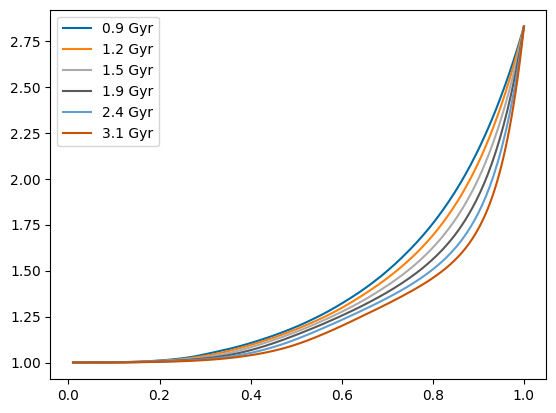

In [24]:
plt.plot(qGrid,malmCorFullResATMO0p9,label='0.9 Gyr')
plt.plot(qGrid,malmCorFullResATMO1p2,label='1.2 Gyr')
plt.plot(qGrid,malmCorFullResATMO1p5,label='1.5 Gyr')
plt.plot(qGrid,malmCorFullResATMO1p9,label='1.9 Gyr')
plt.plot(qGrid,malmCorFullResATMO2p4,label='2.4 Gyr')
plt.plot(qGrid,malmCorFullResATMO3p1,label='3.1 Gyr')
plt.legend()

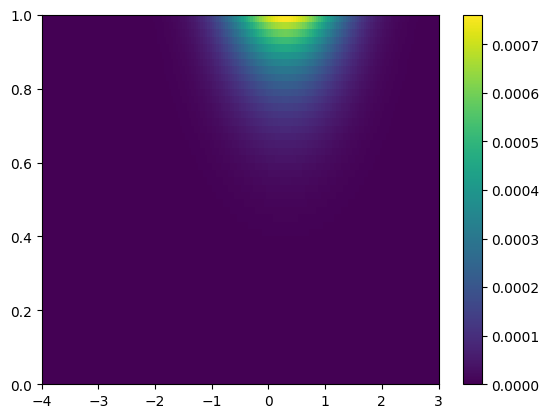

In [25]:
plt.pcolormesh(lpps,qqs,binRate(0.25,6.1,0.3,0.7))#*malmCor[:,None])
plt.colorbar()

In [26]:
def lim(x,n,N,t):
    s = 0
    for i in range(n+1):
        c = np.math.factorial(N+1)/(np.math.factorial(i)*np.math.factorial(N+1-i))
        s += c*np.power(x,i)*np.power(1-x,N+1-i)
    return s - t

/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1592717675.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  c = np.math.factorial(N+1)/(np.math.factorial(i)*np.math.factorial(N+1-i))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/2554716105.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/2554716105.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  meds[i]=opt.fsolve(lim,sc

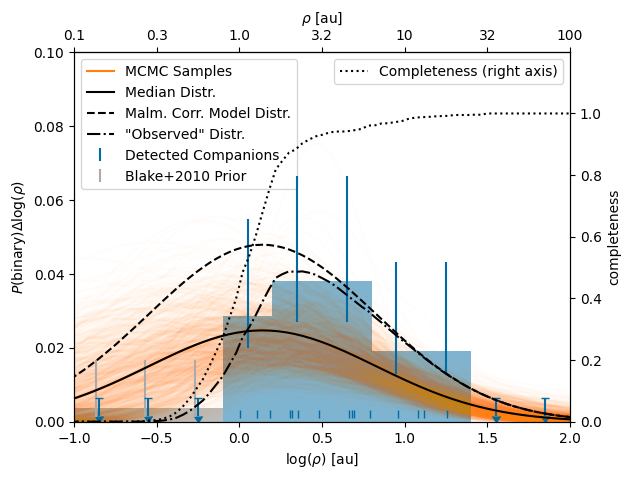

In [27]:
fig,ax = plt.subplots()
counts, bins = np.histogram(np.log10(sepsATMO1p9),bins=10, range=(-1.0,2.0))#,density=1)
scounts = (counts/105.)#*(bins[1]-bins[0])
ax.hist(bins[:-1], bins, weights=scounts,color='C0',alpha=0.5)
ax.errorbar(np.log10(sepsATMO1p9), np.full_like(np.log10(sepsATMO1p9), 0.002), fmt='|C0', markeredgewidth=1)

binCenters = ((bins[1]-bins[0])/2) + bins[0:-1]
#z=1-((1.-0.682689492137086)/2)
#tcounts=np.copy(counts)
#tcounts[np.where(counts==0)]=np.nan
#ecounts = (z/(105*np.sqrt(105)))*np.sqrt(counts*(105-counts))
#pcounts = ecounts*(bins[1]-bins[0])
#plt.errorbar(binCenters[3:8],scounts[3:8],yerr=pcounts[3:8],fmt='C0.')

lebs = np.copy(binCenters)
meds = np.copy(binCenters)
uebs = np.copy(binCenters)
N=105
for i,n in enumerate(counts):
    lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
    meds[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.5))
    uebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.16))

lebs = meds-lebs
uebs = uebs-meds

width = (bins[1]-bins[0])

#lebs*=width
#meds*=width
#uebs*=width

inds = np.random.randint(len(samp1p9BM), size=1000)
#tempDist = np.zeros((1000,80))

for i,ind in enumerate(inds):
    sample = samp1p9BM[ind] 
    tempDist=np.sum(binRatedlp(sample[0],sample[1],sample[2],sample[3]),axis=0)
    ax.plot(pltlogps,tempDist*width, "C1", alpha=0.015)
#medDist = np.median(tempDist,axis=0)

ax.plot(pltlogps,np.sum(binRatedlp(* np.median(samp1p9BM,axis=0))*width,axis=0), "C1",zorder=15, label="MCMC Samples")
ax.plot(pltlogps,np.sum(binRatedlp(* np.median(samp1p9BM,axis=0))*width,axis=0), "k",zorder=15, label="Median Distr.")
modDist = binRatedlp1(* np.median(samp1p9BM,axis=0))*width*malmCorATMO1p9[:,None]
obsDist = modDist*(sensATMO1p9/105.)
ax.plot(logps,np.sum(modDist,axis=0), "k--",zorder=15,label = "Malm. Corr. Model Distr.")
ax.plot(logps,np.sum(obsDist,axis=0), "k-.",zorder=15,label = "\"Observed\" Distr.")
ax2=ax.twinx()
ax2.plot(logps,np.sum(obsDist,axis=0)/np.sum(modDist,axis=0), "k:",zorder=15,label="Completeness (right axis)")
ax2.set_ylabel('completeness')
ax2.set_ylim((0.,1.199))
ax.set_ylim((0.,0.1))
#plt.plot(logps,medDist,'k--')

#plt.errorbar(binCenters,meds,yerr=np.array(list(zip(lebs,uebs))).T,fmt='C0,',uplims=[1,1,1,0,0,0,0,0,1,1])
ax.errorbar(binCenters[3:8],meds[3:8],yerr=np.array(list(zip(lebs[3:8],uebs[3:8]))).T,fmt='C0,',zorder=10,label="Detected Companions")
ax.errorbar(binCenters[[0,1,2,8,9]],meds[[0,1,2,8,9]],yerr=np.array(list(zip(lebs[[0,1,2,8,9]],uebs[[0,1,2,8,9]]))).T,fmt='C0_',uplims=True,zorder=10)
#plt.errorbar(binCenters[[0,1,2,8,9]],meds[[0,1,2,8,9]],yerr=np.array(list(zip(lebs,uebs))).T[:,[0,1,2,8,9]]fmt='C0v',uplims=True)

b10med = 0.025
b10ue  = 0.086
b10le  = 0.016

#width=0.25
#bval = b10med*width/(2./width)
#bue  = b10ue*width/(2./width)
#ble  = b10le*width/(2./width)
bval = b10med/(2./width)
bue  = b10ue/(2./width)
ble  = b10le/(2./width)

ax.errorbar(binCenters[[0,1,2]]-0.02,np.array([bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10, label = "Blake+2010 Prior")
ax.hist(bins[:3],bins[:4],weights=[bval,bval,bval],color='C2',alpha=0.8)
#plt.errorbar([-1.875,-1.625,-1.375,-1.125,-0.875,-0.625,-0.375,-0.125],np.array([bval,bval,bval,bval,bval,bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
#plt.hist([-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25],[-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25,0.],weights=[bval,bval,bval,bval,bval,bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar(binCenters[1],b10med*(bins[3]-bins[0]),yerr=np.array([[b10le,b10ue]]).T*(bins[3]-bins[0]),fmt='C2_')
#plt.plot(logps,np.sum(sensATMO2p4*dqs*dlps/128.67875,axis=0),'C0:')

axup = ax.secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
axup.set_xlabel(r"$\rho$ [au]")
axup.set_xticks(np.logspace(-1,2,7))
#axup.set_xticks([0.1,0.3,0.7,1,3,7,10,30,70,100])
axup.set_xticklabels(['0.1','0.3','1.0','3.2','10','32','100'])

plt.xlim((-1,2.))
ax.set_xlabel(r"$\log (\rho)$ [au]")
ax.set_ylabel(r"$P(\mathrm{binary}) \Delta \log(\rho)$")
ax.legend(loc=2)
ax2.legend()


plt.savefig('figs/binslogpMalm.pdf',bbox_inches='tight')

In [28]:
distr = [ np.sum((binRate(* samp1p9M[i])*malmCorATMO1p9[:,None])[lpps<0.]) for i in np.random.randint(len(samp1p9M), size=10000) ]
print("close sep UI with Malm <1 au: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum(binRate(* samp1p9M[i])[lpps<0.]) for i in np.random.randint(len(samp1p9M), size=10000) ]
print("close sep UI no Malm <1 au: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp1p9BM[i])*malmCorATMO1p9[:,None])[lpps<0.]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("close sep <1 with Malm au: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum(binRate(* samp1p9BM[i])[lpps<0.]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("close sep <1 no Malm au: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp0p9BM[i])*malmCorATMO0p9[:,None])[qqs<0.6]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("low mass 0.9 Gyr: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp1p2BM[i])*malmCorATMO1p2[:,None])[qqs<0.6]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("low mass 1.2 Gyr: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp1p5BM[i])*malmCorATMO1p5[:,None])[qqs<0.6]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("low mass 1.5 Gyr: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp1p9BM[i])*malmCorATMO1p9[:,None])[qqs<0.6]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("low mass 1.9 Gyr: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp2p4BM[i])*malmCorATMO2p4[:,None])[qqs<0.6]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("low mass 2.4 Gyr: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp3p1BM[i])*malmCorATMO3p1[:,None])[qqs<0.6]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("low mass 3.0 Gyr: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum(binRate(* samp1p9BM[i])*malmCorATMO1p9[:,None]*sensATMO1p9/105.) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("total e_bin with Malm: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum(binRate(* samp1p9BM[i])*malmCorATMO1p9[:,None]*sensATMO1p9) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("total n_bin with Malm: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))

close sep UI with Malm <1 au:  1.5316440768404596 [ 1.22304767 -1.15476518]
close sep UI no Malm <1 au:  0.7609375969227279 [ 0.60232547 -0.56661314]
close sep <1 with Malm au:  0.11318659030826701 [ 0.12154975 -0.07133959]
close sep <1 no Malm au:  0.05679332201866755 [ 0.0632933  -0.03558907]
low mass 0.9 Gyr:  0.01173363922148989 [ 0.01555736 -0.00716587]
low mass 1.2 Gyr:  0.008579575939567985 [ 0.01269529 -0.00544107]
low mass 1.5 Gyr:  0.005430323391112867 [ 0.00988178 -0.00378156]
low mass 1.9 Gyr:  0.002722928742585583 [ 0.00621105 -0.00199615]
low mass 2.4 Gyr:  0.0008027853953349023 [ 0.00254211 -0.00064658]
low mass 3.0 Gyr:  0.00024995415740749154 [ 0.00111787 -0.00021837]
total e_bin with Malm:  0.14190450483097147 [ 0.04050412 -0.03292691]
total n_bin with Malm:  14.835382393152567 [ 4.2866809  -3.42696713]


In [29]:
distr = [ np.sum((binRate(* samp1p9BM[i])*malmCorATMO1p9[:,None])[lpps>np.log10(20.)]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("wide sep >20 au: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp1p9BM[i])*malmCorATMO1p9[:,None])[lpps>np.log10(5.)]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("wide sep >5 au: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp1p9BM[i])*malmCorATMO1p9[:,None])[lpps>np.log10(5.)])/np.sum(binRate(* samp1p9BM[i])*malmCorATMO1p9[:,None]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("wide sep >5 au fraction: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp1p9BM[i]))[lpps>np.log10(5.)]) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("raw wide sep >5 au: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))
distr = [ np.sum((binRate(* samp1p9BM[i]))[lpps>np.log10(5.)])/np.sum(binRate(* samp1p9BM[i])) for i in np.random.randint(len(samp1p9BM), size=10000) ]
print("raw wide sep >5 au fraction: ",np.median(distr),np.percentile(distr,[84,16])-np.median(distr))


wide sep >20 au:  0.01111639755230077 [ 0.01276212 -0.00661006]
wide sep >5 au:  0.05788538995926828 [ 0.02352432 -0.01835213]
wide sep >5 au fraction:  0.2168320831661239 [ 0.11803647 -0.08626865]
raw wide sep >5 au:  0.029133855337043657 [ 0.01170961 -0.0096062 ]
raw wide sep >5 au fraction:  0.21454010042528313 [ 0.11443785 -0.08514144]


/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1592717675.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  c = np.math.factorial(N+1)/(np.math.factorial(i)*np.math.factorial(N+1-i))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1042106400.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1042106400.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  meds[i]=opt.fsolve(lim,sc

<Figure size 640x480 with 0 Axes>

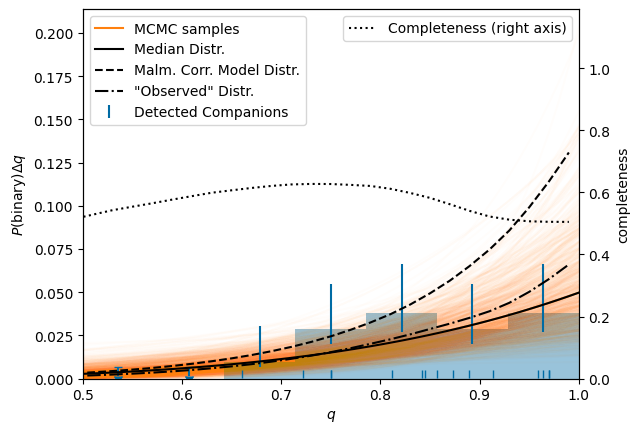

In [30]:
plt.clf()
fig,ax = plt.subplots()
counts, bins = np.histogram(qsATMO0p9,bins=7, range=(0.5,1.0))#,density=1)
scounts = (counts/105.)#*(bins[1]-bins[0])
ax.hist(bins[:-1], bins, weights=scounts,color='C0',alpha=0.4)
ax.errorbar(qsATMO0p9, np.full_like(qsATMO0p9, 0.003), fmt='|C0', markeredgewidth=1)

binCenters = ((bins[1]-bins[0])/2) + bins[0:-1]
#z=1-((1.-0.682689492137086)/2)
#tcounts=np.copy(counts)
#tcounts[np.where(counts==0)]=np.nan
#ecounts = (z/(105*np.sqrt(105)))*np.sqrt(counts*(105-counts))
#pcounts = ecounts*(bins[1]-bins[0])
#plt.errorbar(binCenters[3:8],scounts[3:8],yerr=pcounts[3:8],fmt='C0.')

lebs = np.copy(binCenters)
meds = np.copy(binCenters)
uebs = np.copy(binCenters)
N=105
for i,n in enumerate(counts):
    lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
    meds[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.5))
    uebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.16))

lebs = meds-lebs
uebs = uebs-meds

width = (bins[1]-bins[0])

#lebs*=width
#meds*=width
#uebs*=width

inds = np.random.randint(len(samp0p9BM), size=1000)
#tempDist = np.zeros((1000,80))

for i,ind in enumerate(inds):
    sample = samp0p9BM[ind] 
    tempDist=np.sum(binRatedq(sample[0],sample[1],sample[2],sample[3]),axis=1)
    ax.plot(pltqs,tempDist*width, "C1", alpha=0.015)
#medDist = np.median(tempDist,axis=0)

ax.plot(pltqs,np.sum(binRatedq(* np.median(samp0p9BM,axis=0))*width,axis=1), "C1",label = "MCMC samples")
ax.plot(pltqs,np.sum(binRatedq(* np.median(samp0p9BM,axis=0))*width,axis=1), "k",zorder=15, label="Median Distr.")
modDist = binRatedq1(* np.median(samp0p9BM,axis=0))*width*malmCorATMO0p9[:,None]
obsDist = modDist*sensATMO0p9/105.
ax.plot(qs,np.sum(modDist,axis=1), "k--",zorder=15,label = "Malm. Corr. Model Distr.")
ax.plot(qs,np.sum(obsDist,axis=1), "k-.",zorder=15,label = "\"Observed\" Distr.")
ax2=ax.twinx()
ax2.plot(qs,np.sum(obsDist,axis=1)/np.sum(modDist,axis=1), "k:",zorder=15,label="Completeness (right axis)")
# ax2.plot(qs,np.sum(sensATMO0p9/105.,axis=1), "k:",zorder=15,label="Completeness (right axis)")
ax2.set_ylabel('completeness')
ax2.set_ylim((0.,1.19))
# plt.plot(pltqs,np.sum(binRatedq(* np.median(samp1p9B,axis=0))*width,axis=1), "k",zorder=15)
# plt.plot(qs,np.sum(binRatedq1(* np.median(samp1p9B,axis=0))*width*sensATMO1p9/105.,axis=1), "k--",zorder=15)
#plt.plot(logps,medDist,'k--')

ax.errorbar(binCenters[2:],meds[2:],yerr=np.array(list(zip(lebs[2:],uebs[2:]))).T,fmt='C0,',zorder=10,label="Detected Companions")
ax.errorbar(binCenters[[0,1]],meds[[0,1]],yerr=np.array(list(zip(lebs[[0,1]],uebs[[0,1]]))).T,fmt='C0_',uplims=True,zorder=10)
#plt.errorbar(binCenters,meds,yerr=np.array(list(zip(lebs,uebs))).T,fmt='C0,',uplims=[1,1,1,0,0,0,0,0,1,1])
#plt.errorbar(binCenters[[0,1,2,8,9]],meds[[0,1,2,8,9]],yerr=np.array(list(zip(lebs,uebs))).T[:,[0,1,2,8,9]]fmt='C0v',uplims=True)

# b10med = 0.025
# b10ue  = 0.086
# b10le  = 0.016

# #width=0.25
# #bval = b10med*width/(2./width)
# #bue  = b10ue*width/(2./width)
# #ble  = b10le*width/(2./width)
# bval = b10med/(2./width)
# bue  = b10ue/(2./width)
# ble  = b10le/(2./width)

# plt.errorbar(binCenters[[0,1,2]]-0.02,np.array([bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
# plt.hist(bins[:3],bins[:4],weights=[bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar([-1.875,-1.625,-1.375,-1.125,-0.875,-0.625,-0.375,-0.125],np.array([bval,bval,bval,bval,bval,bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
#plt.hist([-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25],[-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25,0.],weights=[bval,bval,bval,bval,bval,bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar(binCenters[1],b10med*(bins[3]-bins[0]),yerr=np.array([[b10le,b10ue]]).T*(bins[3]-bins[0]),fmt='C2_')
#plt.plot(logps,np.sum(sensATMO2p4*dqs*dlps/128.67875,axis=0),'C0:')

plt.xlim((0.5,1.))
ymin,ymax = ax.get_ylim()
#ax.set_ylim((0.0,0.15))
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$P(\mathrm{binary}) \Delta q$")
ax.legend(loc=2)
ax2.legend(loc=1)


plt.savefig('figs/binsq0p9GyrMalm.pdf',bbox_inches='tight')

/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1592717675.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  c = np.math.factorial(N+1)/(np.math.factorial(i)*np.math.factorial(N+1-i))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/3376785138.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/3376785138.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  meds[i]=opt.fsolve(lim,sc

<Figure size 640x480 with 0 Axes>

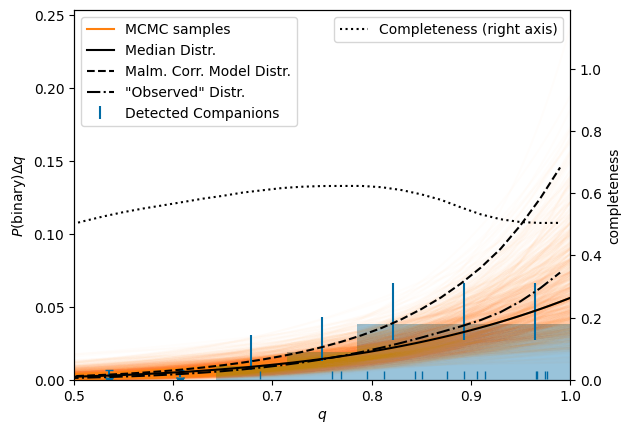

In [31]:
plt.clf()
fig,ax = plt.subplots()
counts, bins = np.histogram(qsATMO1p2,bins=7, range=(0.5,1.0))#,density=1)
scounts = (counts/105.)#*(bins[1]-bins[0])
ax.hist(bins[:-1], bins, weights=scounts,color='C0',alpha=0.4)
ax.errorbar(qsATMO1p2, np.full_like(qsATMO1p2, 0.003), fmt='|C0', markeredgewidth=1)

binCenters = ((bins[1]-bins[0])/2) + bins[0:-1]
#z=1-((1.-0.682689492137086)/2)
#tcounts=np.copy(counts)
#tcounts[np.where(counts==0)]=np.nan
#ecounts = (z/(105*np.sqrt(105)))*np.sqrt(counts*(105-counts))
#pcounts = ecounts*(bins[1]-bins[0])
#plt.errorbar(binCenters[3:8],scounts[3:8],yerr=pcounts[3:8],fmt='C0.')

lebs = np.copy(binCenters)
meds = np.copy(binCenters)
uebs = np.copy(binCenters)
N=105
for i,n in enumerate(counts):
    lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
    meds[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.5))
    uebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.16))

lebs = meds-lebs
uebs = uebs-meds

width = (bins[1]-bins[0])

#lebs*=width
#meds*=width
#uebs*=width

inds = np.random.randint(len(samp1p2BM), size=1000)
#tempDist = np.zeros((1000,80))

for i,ind in enumerate(inds):
    sample = samp1p2BM[ind] 
    tempDist=np.sum(binRatedq(sample[0],sample[1],sample[2],sample[3]),axis=1)
    ax.plot(pltqs,tempDist*width, "C1", alpha=0.015)
#medDist = np.median(tempDist,axis=0)

ax.plot(pltqs,np.sum(binRatedq(* np.median(samp1p2BM,axis=0))*width,axis=1), "C1",label = "MCMC samples")
ax.plot(pltqs,np.sum(binRatedq(* np.median(samp1p2BM,axis=0))*width,axis=1), "k",zorder=15, label="Median Distr.")
modDist = binRatedq1(* np.median(samp1p2BM,axis=0))*width*malmCorATMO1p2[:,None]
obsDist = modDist*sensATMO1p2/105.
ax.plot(qs,np.sum(modDist,axis=1), "k--",zorder=15,label = "Malm. Corr. Model Distr.")
ax.plot(qs,np.sum(obsDist,axis=1), "k-.",zorder=15,label = "\"Observed\" Distr.")
ax2=ax.twinx()
ax2.plot(qs,np.sum(obsDist,axis=1)/np.sum(modDist,axis=1), "k:",zorder=15,label="Completeness (right axis)")
ax2.set_ylabel('completeness')
ax2.set_ylim((0.,1.19))
# plt.plot(pltqs,np.sum(binRatedq(* np.median(samp1p9B,axis=0))*width,axis=1), "k",zorder=15)
# plt.plot(qs,np.sum(binRatedq1(* np.median(samp1p9B,axis=0))*width*sensATMO1p9/105.,axis=1), "k--",zorder=15)
#plt.plot(logps,medDist,'k--')

ax.errorbar(binCenters[2:],meds[2:],yerr=np.array(list(zip(lebs[2:],uebs[2:]))).T,fmt='C0,',zorder=10,label="Detected Companions")
ax.errorbar(binCenters[[0,1]],meds[[0,1]],yerr=np.array(list(zip(lebs[[0,1]],uebs[[0,1]]))).T,fmt='C0_',uplims=True,zorder=10)
#plt.errorbar(binCenters,meds,yerr=np.array(list(zip(lebs,uebs))).T,fmt='C0,',uplims=[1,1,1,0,0,0,0,0,1,1])
#plt.errorbar(binCenters[[0,1,2,8,9]],meds[[0,1,2,8,9]],yerr=np.array(list(zip(lebs,uebs))).T[:,[0,1,2,8,9]]fmt='C0v',uplims=True)

# b10med = 0.025
# b10ue  = 0.086
# b10le  = 0.016

# #width=0.25
# #bval = b10med*width/(2./width)
# #bue  = b10ue*width/(2./width)
# #ble  = b10le*width/(2./width)
# bval = b10med/(2./width)
# bue  = b10ue/(2./width)
# ble  = b10le/(2./width)

# plt.errorbar(binCenters[[0,1,2]]-0.02,np.array([bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
# plt.hist(bins[:3],bins[:4],weights=[bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar([-1.875,-1.625,-1.375,-1.125,-0.875,-0.625,-0.375,-0.125],np.array([bval,bval,bval,bval,bval,bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
#plt.hist([-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25],[-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25,0.],weights=[bval,bval,bval,bval,bval,bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar(binCenters[1],b10med*(bins[3]-bins[0]),yerr=np.array([[b10le,b10ue]]).T*(bins[3]-bins[0]),fmt='C2_')
#plt.plot(logps,np.sum(sensATMO2p4*dqs*dlps/128.67875,axis=0),'C0:')

plt.xlim((0.5,1.))
ymin,ymax = ax.get_ylim()
#ax.set_ylim((0.0,0.2))
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$P(\mathrm{binary}) \Delta q$")
ax.legend(loc=2)
ax2.legend(loc=1)


plt.savefig('figs/binsq1p2GyrMalm.pdf',bbox_inches='tight')

/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1592717675.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  c = np.math.factorial(N+1)/(np.math.factorial(i)*np.math.factorial(N+1-i))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/2618359982.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/2618359982.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  meds[i]=opt.fsolve(lim,sc

<Figure size 640x480 with 0 Axes>

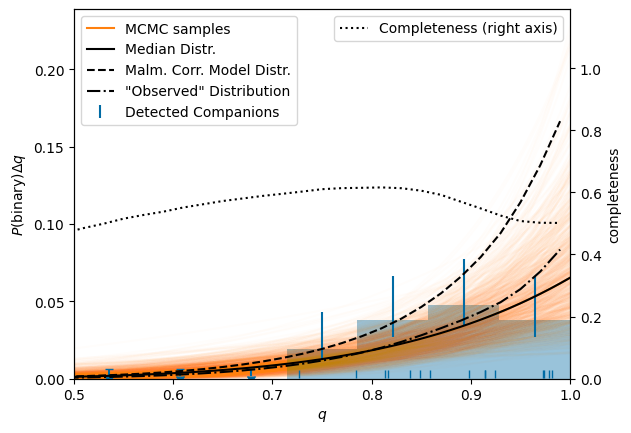

In [32]:
plt.clf()
fig,ax = plt.subplots()
counts, bins = np.histogram(qsATMO1p5,bins=7, range=(0.5,1.0))#,density=1)
scounts = (counts/105.)#*(bins[1]-bins[0])
ax.hist(bins[:-1], bins, weights=scounts,color='C0',alpha=0.4)
ax.errorbar(qsATMO1p5, np.full_like(qsATMO1p5, 0.003), fmt='|C0', markeredgewidth=1)

binCenters = ((bins[1]-bins[0])/2) + bins[0:-1]
#z=1-((1.-0.682689492137086)/2)
#tcounts=np.copy(counts)
#tcounts[np.where(counts==0)]=np.nan
#ecounts = (z/(105*np.sqrt(105)))*np.sqrt(counts*(105-counts))
#pcounts = ecounts*(bins[1]-bins[0])
#plt.errorbar(binCenters[3:8],scounts[3:8],yerr=pcounts[3:8],fmt='C0.')

lebs = np.copy(binCenters)
meds = np.copy(binCenters)
uebs = np.copy(binCenters)
N=105
for i,n in enumerate(counts):
    lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
    meds[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.5))
    uebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.16))

lebs = meds-lebs
uebs = uebs-meds

width = (bins[1]-bins[0])

#lebs*=width
#meds*=width
#uebs*=width

inds = np.random.randint(len(samp1p5BM), size=1000)
#tempDist = np.zeros((1000,80))

for i,ind in enumerate(inds):
    sample = samp1p5BM[ind] 
    tempDist=np.sum(binRatedq(sample[0],sample[1],sample[2],sample[3]),axis=1)
    ax.plot(pltqs,tempDist*width, "C1", alpha=0.015)
#medDist = np.median(tempDist,axis=0)

ax.plot(pltqs,np.sum(binRatedq(* np.median(samp1p5BM,axis=0))*width,axis=1), "C1",label = "MCMC samples")
ax.plot(pltqs,np.sum(binRatedq(* np.median(samp1p5BM,axis=0))*width,axis=1), "k",zorder=15, label="Median Distr.")
modDist = binRatedq1(* np.median(samp1p5BM,axis=0))*width*malmCorATMO1p5[:,None]
obsDist = modDist*sensATMO1p5/105.
ax.plot(qs,np.sum(modDist,axis=1), "k--",zorder=15,label = "Malm. Corr. Model Distr.")
ax.plot(qs,np.sum(obsDist,axis=1), "k-.",zorder=15,label = "\"Observed\" Distribution")
ax2=ax.twinx()
ax2.plot(qs,np.sum(obsDist,axis=1)/np.sum(modDist,axis=1), "k:",zorder=15,label="Completeness (right axis)")
ax2.set_ylabel('completeness')
ax2.set_ylim((0.,1.19))
# plt.plot(pltqs,np.sum(binRatedq(* np.median(samp1p9B,axis=0))*width,axis=1), "k",zorder=15)
# plt.plot(qs,np.sum(binRatedq1(* np.median(samp1p9B,axis=0))*width*sensATMO1p9/105.,axis=1), "k--",zorder=15)
#plt.plot(logps,medDist,'k--')

ax.errorbar(binCenters[3:],meds[3:],yerr=np.array(list(zip(lebs[3:],uebs[3:]))).T,fmt='C0,',zorder=10,label="Detected Companions")
ax.errorbar(binCenters[[0,1,2]],meds[[0,1,2]],yerr=np.array(list(zip(lebs[[0,1,2]],uebs[[0,1,2]]))).T,fmt='C0_',uplims=True,zorder=10)
#plt.errorbar(binCenters,meds,yerr=np.array(list(zip(lebs,uebs))).T,fmt='C0,',uplims=[1,1,1,0,0,0,0,0,1,1])
#plt.errorbar(binCenters[[0,1,2,8,9]],meds[[0,1,2,8,9]],yerr=np.array(list(zip(lebs,uebs))).T[:,[0,1,2,8,9]]fmt='C0v',uplims=True)

# b10med = 0.025
# b10ue  = 0.086
# b10le  = 0.016

# #width=0.25
# #bval = b10med*width/(2./width)
# #bue  = b10ue*width/(2./width)
# #ble  = b10le*width/(2./width)
# bval = b10med/(2./width)
# bue  = b10ue/(2./width)
# ble  = b10le/(2./width)

# plt.errorbar(binCenters[[0,1,2]]-0.02,np.array([bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
# plt.hist(bins[:3],bins[:4],weights=[bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar([-1.875,-1.625,-1.375,-1.125,-0.875,-0.625,-0.375,-0.125],np.array([bval,bval,bval,bval,bval,bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
#plt.hist([-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25],[-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25,0.],weights=[bval,bval,bval,bval,bval,bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar(binCenters[1],b10med*(bins[3]-bins[0]),yerr=np.array([[b10le,b10ue]]).T*(bins[3]-bins[0]),fmt='C2_')
#plt.plot(logps,np.sum(sensATMO2p4*dqs*dlps/128.67875,axis=0),'C0:')

plt.xlim((0.5,1.))
ymin,ymax = ax.get_ylim()
#ax.set_ylim((0.0,0.2))
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$P(\mathrm{binary}) \Delta q$")
ax.legend(loc=2)
ax2.legend(loc=1)


plt.savefig('figs/binsq1p5GyrMalm.pdf',bbox_inches='tight')

/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1592717675.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  c = np.math.factorial(N+1)/(np.math.factorial(i)*np.math.factorial(N+1-i))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/561716389.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/561716389.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  meds[i]=opt.fsolve(lim,scou

<Figure size 640x480 with 0 Axes>

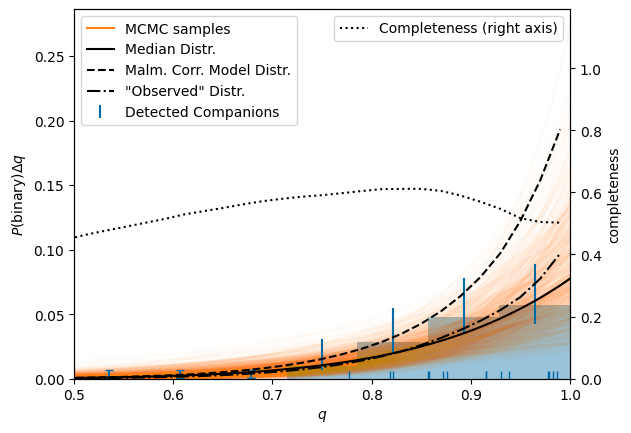

In [33]:
plt.clf()
fig,ax = plt.subplots()
counts, bins = np.histogram(qsATMO1p9,bins=7, range=(0.5,1.0))#,density=1)
scounts = (counts/105.)#*(bins[1]-bins[0])
ax.hist(bins[:-1], bins, weights=scounts,color='C0',alpha=0.4)
ax.errorbar(qsATMO1p9, np.full_like(qsATMO1p9, 0.003), fmt='|C0', markeredgewidth=1)

binCenters = ((bins[1]-bins[0])/2) + bins[0:-1]
#z=1-((1.-0.682689492137086)/2)
#tcounts=np.copy(counts)
#tcounts[np.where(counts==0)]=np.nan
#ecounts = (z/(105*np.sqrt(105)))*np.sqrt(counts*(105-counts))
#pcounts = ecounts*(bins[1]-bins[0])
#plt.errorbar(binCenters[3:8],scounts[3:8],yerr=pcounts[3:8],fmt='C0.')

lebs = np.copy(binCenters)
meds = np.copy(binCenters)
uebs = np.copy(binCenters)
N=105
for i,n in enumerate(counts):
    lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
    meds[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.5))
    uebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.16))

lebs = meds-lebs
uebs = uebs-meds

width = (bins[1]-bins[0])

#lebs*=width
#meds*=width
#uebs*=width

inds = np.random.randint(len(samp1p9BM), size=1000)
#tempDist = np.zeros((1000,80))

for i,ind in enumerate(inds):
    sample = samp1p9BM[ind] 
    tempDist=np.sum(binRatedq(sample[0],sample[1],sample[2],sample[3]),axis=1)
    ax.plot(pltqs,tempDist*width, "C1", alpha=0.015)
#medDist = np.median(tempDist,axis=0)

ax.plot(pltqs,np.sum(binRatedq(* np.median(samp1p9BM,axis=0))*width,axis=1), "C1",label = "MCMC samples")
ax.plot(pltqs,np.sum(binRatedq(* np.median(samp1p9BM,axis=0))*width,axis=1), "k",zorder=15, label="Median Distr.")
modDist = binRatedq1(* np.median(samp1p9BM,axis=0))*width*malmCorATMO1p9[:,None]
obsDist = modDist*sensATMO1p9/105.
ax.plot(qs,np.sum(modDist,axis=1), "k--",zorder=15,label = "Malm. Corr. Model Distr.")
ax.plot(qs,np.sum(obsDist,axis=1), "k-.",zorder=15,label = "\"Observed\" Distr.")
ax2=ax.twinx()
ax2.plot(qs,np.sum(obsDist,axis=1)/np.sum(modDist,axis=1), "k:",zorder=15,label="Completeness (right axis)")
ax2.set_ylabel('completeness')
ax2.set_ylim((0.,1.19))
# plt.plot(pltqs,np.sum(binRatedq(* np.median(samp1p9B,axis=0))*width,axis=1), "k",zorder=15)
# plt.plot(qs,np.sum(binRatedq1(* np.median(samp1p9B,axis=0))*width*sensATMO1p9/105.,axis=1), "k--",zorder=15)
#plt.plot(logps,medDist,'k--')

ax.errorbar(binCenters[3:],meds[3:],yerr=np.array(list(zip(lebs[3:],uebs[3:]))).T,fmt='C0,',zorder=10,label="Detected Companions")
ax.errorbar(binCenters[[0,1,2]],meds[[0,1,2]],yerr=np.array(list(zip(lebs[[0,1,2]],uebs[[0,1,2]]))).T,fmt='C0_',uplims=True,zorder=10)
#plt.errorbar(binCenters,meds,yerr=np.array(list(zip(lebs,uebs))).T,fmt='C0,',uplims=[1,1,1,0,0,0,0,0,1,1])
#plt.errorbar(binCenters[[0,1,2,8,9]],meds[[0,1,2,8,9]],yerr=np.array(list(zip(lebs,uebs))).T[:,[0,1,2,8,9]]fmt='C0v',uplims=True)

# b10med = 0.025
# b10ue  = 0.086
# b10le  = 0.016

# #width=0.25
# #bval = b10med*width/(2./width)
# #bue  = b10ue*width/(2./width)
# #ble  = b10le*width/(2./width)
# bval = b10med/(2./width)
# bue  = b10ue/(2./width)
# ble  = b10le/(2./width)

# plt.errorbar(binCenters[[0,1,2]]-0.02,np.array([bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
# plt.hist(bins[:3],bins[:4],weights=[bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar([-1.875,-1.625,-1.375,-1.125,-0.875,-0.625,-0.375,-0.125],np.array([bval,bval,bval,bval,bval,bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
#plt.hist([-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25],[-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25,0.],weights=[bval,bval,bval,bval,bval,bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar(binCenters[1],b10med*(bins[3]-bins[0]),yerr=np.array([[b10le,b10ue]]).T*(bins[3]-bins[0]),fmt='C2_')
#plt.plot(logps,np.sum(sensATMO2p4*dqs*dlps/128.67875,axis=0),'C0:')

plt.xlim((0.5,1.))
ymin,ymax = ax.get_ylim()
# ax.set_ylim((0.0,0.2))
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$P(\mathrm{binary}) \Delta q$")
ax.legend(loc=2)
ax2.legend(loc=1)


plt.savefig('figs/binsq1p9GyrMalm.pdf',bbox_inches='tight')

/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1592717675.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  c = np.math.factorial(N+1)/(np.math.factorial(i)*np.math.factorial(N+1-i))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/470079565.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/470079565.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  meds[i]=opt.fsolve(lim,scou

<Figure size 640x480 with 0 Axes>

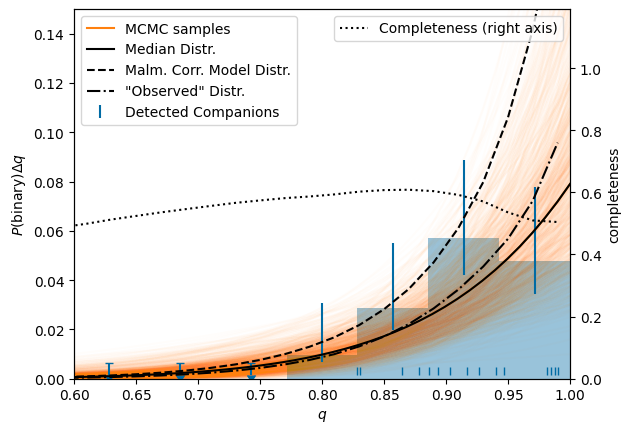

In [34]:
plt.clf()
fig,ax = plt.subplots()
counts, bins = np.histogram(qsATMO2p4,bins=7, range=(0.6,1.0))#,density=1)
scounts = (counts/105.)#*(bins[1]-bins[0])
ax.hist(bins[:-1], bins, weights=scounts,color='C0',alpha=0.4)
ax.errorbar(qsATMO2p4, np.full_like(qsATMO2p4, 0.003), fmt='|C0', markeredgewidth=1)

binCenters = ((bins[1]-bins[0])/2) + bins[0:-1]
#z=1-((1.-0.682689492137086)/2)
#tcounts=np.copy(counts)
#tcounts[np.where(counts==0)]=np.nan
#ecounts = (z/(105*np.sqrt(105)))*np.sqrt(counts*(105-counts))
#pcounts = ecounts*(bins[1]-bins[0])
#plt.errorbar(binCenters[3:8],scounts[3:8],yerr=pcounts[3:8],fmt='C0.')

lebs = np.copy(binCenters)
meds = np.copy(binCenters)
uebs = np.copy(binCenters)
N=105
for i,n in enumerate(counts):
    lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
    meds[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.5))
    uebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.16))

lebs = meds-lebs
uebs = uebs-meds

width = (bins[1]-bins[0])

#lebs*=width
#meds*=width
#uebs*=width

inds = np.random.randint(len(samp2p4BM), size=1000)
#tempDist = np.zeros((1000,80))

for i,ind in enumerate(inds):
    sample = samp2p4BM[ind] 
    tempDist=np.sum(binRatedq(sample[0],sample[1],sample[2],sample[3]),axis=1)
    ax.plot(pltqs,tempDist*width, "C1", alpha=0.015)
#medDist = np.median(tempDist,axis=0)

ax.plot(pltqs,np.sum(binRatedq(* np.median(samp2p4BM,axis=0))*width,axis=1), "C1",label = "MCMC samples")
ax.plot(pltqs,np.sum(binRatedq(* np.median(samp2p4BM,axis=0))*width,axis=1), "k",zorder=15, label="Median Distr.")
modDist = binRatedq1(* np.median(samp2p4BM,axis=0))*width*malmCorATMO2p4[:,None]
obsDist = modDist*sensATMO2p4/105.
ax.plot(qs,np.sum(modDist,axis=1), "k--",zorder=15,label = "Malm. Corr. Model Distr.")
ax.plot(qs,np.sum(obsDist,axis=1), "k-.",zorder=15,label = "\"Observed\" Distr.")
ax2=ax.twinx()
ax2.plot(qs,np.sum(obsDist,axis=1)/np.sum(modDist,axis=1), "k:",zorder=15,label="Completeness (right axis)")
ax2.set_ylabel('completeness')
ax2.set_ylim((0.,1.19))
# plt.plot(pltqs,np.sum(binRatedq(* np.median(samp1p9B,axis=0))*width,axis=1), "k",zorder=15)
# plt.plot(qs,np.sum(binRatedq1(* np.median(samp1p9B,axis=0))*width*sensATMO1p9/105.,axis=1), "k--",zorder=15)
#plt.plot(logps,medDist,'k--')

ax.errorbar(binCenters[3:],meds[3:],yerr=np.array(list(zip(lebs[3:],uebs[3:]))).T,fmt='C0,',zorder=10,label="Detected Companions")
ax.errorbar(binCenters[[0,1,2]],meds[[0,1,2]],yerr=np.array(list(zip(lebs[[0,1,2]],uebs[[0,1,2]]))).T,fmt='C0_',uplims=True,zorder=10)
#plt.errorbar(binCenters,meds,yerr=np.array(list(zip(lebs,uebs))).T,fmt='C0,',uplims=[1,1,1,0,0,0,0,0,1,1])
#plt.errorbar(binCenters[[0,1,2,8,9]],meds[[0,1,2,8,9]],yerr=np.array(list(zip(lebs,uebs))).T[:,[0,1,2,8,9]]fmt='C0v',uplims=True)

# b10med = 0.025
# b10ue  = 0.086
# b10le  = 0.016

# #width=0.25
# #bval = b10med*width/(2./width)
# #bue  = b10ue*width/(2./width)
# #ble  = b10le*width/(2./width)
# bval = b10med/(2./width)
# bue  = b10ue/(2./width)
# ble  = b10le/(2./width)

# plt.errorbar(binCenters[[0,1,2]]-0.02,np.array([bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
# plt.hist(bins[:3],bins[:4],weights=[bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar([-1.875,-1.625,-1.375,-1.125,-0.875,-0.625,-0.375,-0.125],np.array([bval,bval,bval,bval,bval,bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
#plt.hist([-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25],[-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25,0.],weights=[bval,bval,bval,bval,bval,bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar(binCenters[1],b10med*(bins[3]-bins[0]),yerr=np.array([[b10le,b10ue]]).T*(bins[3]-bins[0]),fmt='C2_')
#plt.plot(logps,np.sum(sensATMO2p4*dqs*dlps/128.67875,axis=0),'C0:')

plt.xlim((0.6,1.))
ymin,ymax = ax.get_ylim()
ax.set_ylim((0.0,0.15))
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$P(\mathrm{binary}) \Delta q$")
ax.legend(loc=2)
ax2.legend(loc=1)


plt.savefig('figs/binsq2p4GyrMalm.pdf',bbox_inches='tight')

/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/1592717675.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  c = np.math.factorial(N+1)/(np.math.factorial(i)*np.math.factorial(N+1-i))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/3591179078.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/3591179078.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  meds[i]=opt.fsolve(lim,sc

<Figure size 640x480 with 0 Axes>

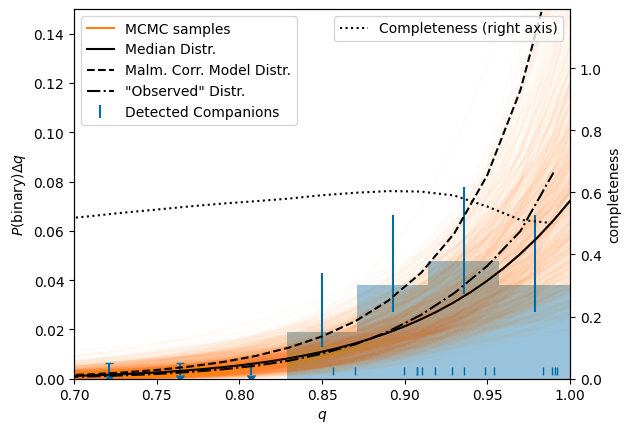

In [36]:
plt.clf()
fig,ax = plt.subplots()
counts, bins = np.histogram(qsATMO3p1,bins=7, range=(0.7,1.0))#,density=1)
scounts = (counts/105.)#*(bins[1]-bins[0])
ax.hist(bins[:-1], bins, weights=scounts,color='C0',alpha=0.4)
ax.errorbar(qsATMO3p1, np.full_like(qsATMO3p1, 0.003), fmt='|C0', markeredgewidth=1)

binCenters = ((bins[1]-bins[0])/2) + bins[0:-1]
#z=1-((1.-0.682689492137086)/2)
#tcounts=np.copy(counts)
#tcounts[np.where(counts==0)]=np.nan
#ecounts = (z/(105*np.sqrt(105)))*np.sqrt(counts*(105-counts))
#pcounts = ecounts*(bins[1]-bins[0])
#plt.errorbar(binCenters[3:8],scounts[3:8],yerr=pcounts[3:8],fmt='C0.')

lebs = np.copy(binCenters)
meds = np.copy(binCenters)
uebs = np.copy(binCenters)
N=105
for i,n in enumerate(counts):
    lebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.84))
    meds[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.5))
    uebs[i]=opt.fsolve(lim,scounts[i],args=(n,N,0.16))

lebs = meds-lebs
uebs = uebs-meds

width = (bins[1]-bins[0])

#lebs*=width
#meds*=width
#uebs*=width

inds = np.random.randint(len(samp3p1BM), size=1000)
#tempDist = np.zeros((1000,80))

for i,ind in enumerate(inds):
    sample = samp3p1BM[ind] 
    tempDist=np.sum(binRatedq(sample[0],sample[1],sample[2],sample[3]),axis=1)
    ax.plot(pltqs,tempDist*width, "C1", alpha=0.015)
#medDist = np.median(tempDist,axis=0)

ax.plot(pltqs,np.sum(binRatedq(* np.median(samp3p1BM,axis=0))*width,axis=1), "C1",label = "MCMC samples")
ax.plot(pltqs,np.sum(binRatedq(* np.median(samp3p1BM,axis=0))*width,axis=1), "k",zorder=15, label="Median Distr.")
modDist = binRatedq1(* np.median(samp3p1BM,axis=0))*width*malmCorATMO3p1[:,None]
obsDist = modDist*sensATMO3p1/105.
ax.plot(qs,np.sum(modDist,axis=1), "k--",zorder=15,label = "Malm. Corr. Model Distr.")
ax.plot(qs,np.sum(obsDist,axis=1), "k-.",zorder=15,label = "\"Observed\" Distr.")
ax2=ax.twinx()
ax2.plot(qs,np.sum(obsDist,axis=1)/np.sum(modDist,axis=1), "k:",zorder=15,label="Completeness (right axis)")
ax2.set_ylabel('completeness')
ax2.set_ylim((0.,1.19))
# plt.plot(pltqs,np.sum(binRatedq(* np.median(samp1p9B,axis=0))*width,axis=1), "k",zorder=15)
# plt.plot(qs,np.sum(binRatedq1(* np.median(samp1p9B,axis=0))*width*sensATMO1p9/105.,axis=1), "k--",zorder=15)
#plt.plot(logps,medDist,'k--')

ax.errorbar(binCenters[3:],meds[3:],yerr=np.array(list(zip(lebs[3:],uebs[3:]))).T,fmt='C0,',zorder=10,label="Detected Companions")
ax.errorbar(binCenters[[0,1,2]],meds[[0,1,2]],yerr=np.array(list(zip(lebs[[0,1,2]],uebs[[0,1,2]]))).T,fmt='C0_',uplims=True,zorder=10)
#plt.errorbar(binCenters,meds,yerr=np.array(list(zip(lebs,uebs))).T,fmt='C0,',uplims=[1,1,1,0,0,0,0,0,1,1])
#plt.errorbar(binCenters[[0,1,2,8,9]],meds[[0,1,2,8,9]],yerr=np.array(list(zip(lebs,uebs))).T[:,[0,1,2,8,9]]fmt='C0v',uplims=True)

# b10med = 0.025
# b10ue  = 0.086
# b10le  = 0.016

# #width=0.25
# #bval = b10med*width/(2./width)
# #bue  = b10ue*width/(2./width)
# #ble  = b10le*width/(2./width)
# bval = b10med/(2./width)
# bue  = b10ue/(2./width)
# ble  = b10le/(2./width)

# plt.errorbar(binCenters[[0,1,2]]-0.02,np.array([bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
# plt.hist(bins[:3],bins[:4],weights=[bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar([-1.875,-1.625,-1.375,-1.125,-0.875,-0.625,-0.375,-0.125],np.array([bval,bval,bval,bval,bval,bval,bval,bval]),yerr=np.array([[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue],[ble,bue]]).T,fmt='C2,',zorder=10)
#plt.hist([-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25],[-2.,-1.75,-1.5,-1.25,-1.,-0.75,-0.5,-0.25,0.],weights=[bval,bval,bval,bval,bval,bval,bval,bval],color='C2',alpha=0.5)
#plt.errorbar(binCenters[1],b10med*(bins[3]-bins[0]),yerr=np.array([[b10le,b10ue]]).T*(bins[3]-bins[0]),fmt='C2_')
#plt.plot(logps,np.sum(sensATMO2p4*dqs*dlps/128.67875,axis=0),'C0:')

plt.xlim((0.7,1.))
ymin,ymax = ax.get_ylim()
ax.set_ylim((0.0,0.15))
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$P(\mathrm{binary}) \Delta q$")
ax.legend(loc=2)
ax2.legend(loc=1)


plt.savefig('figs/binsq3p1GyrMalm.pdf',bbox_inches='tight')

In [37]:
pltsenss = [np.copy(sensATMO0p9),np.copy(sensATMO1p2),np.copy(sensATMO1p5),np.copy(sensATMO1p9),np.copy(sensATMO2p4),np.copy(sensATMO3p1)]
malmCors = [malmCorATMO0p9,malmCorATMO1p2,malmCorATMO1p5,malmCorATMO1p9,malmCorATMO2p4,malmCorATMO3p1]
detss = [detsATMO0p9,detsATMO1p2,detsATMO1p5,detsATMO1p9,detsATMO2p4,detsATMO3p1]
samps = [samp0p9BM,samp1p2BM,samp1p5BM,samp1p9BM,samp2p4BM,samp3p1BM]
ageStrs = ['0p9','1p2','1p5','1p9','2p4','3p1']

/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/923688146.py:31: RuntimeWarning: divide by zero encountered in log10
  axup = axs[0].secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/923688146.py:49: RuntimeWarning: divide by zero encountered in log10
  axup = axs[1].secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/923688146.py:67: RuntimeWarning: divide by zero encountered in log10
  axup = axs[2].secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/923688146.py:31: RuntimeWarning: divide by zero encountered in log10
  axup = axs[0].secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
/var/folders/zt/dh97bp9s50189s1krh7lqrrr0000gn/T/ipykernel_5233/923688146.py:49: RuntimeWarning: divide 

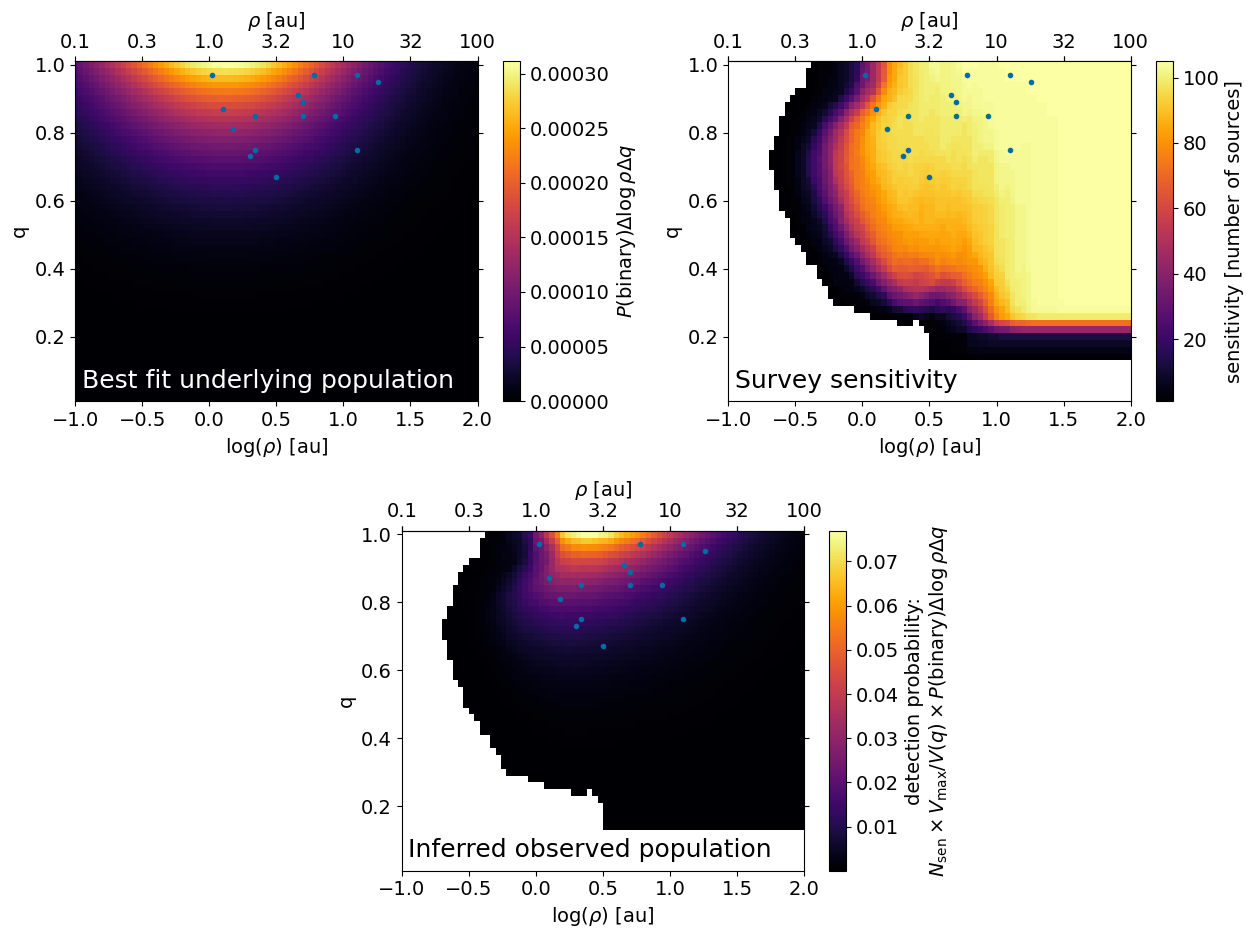

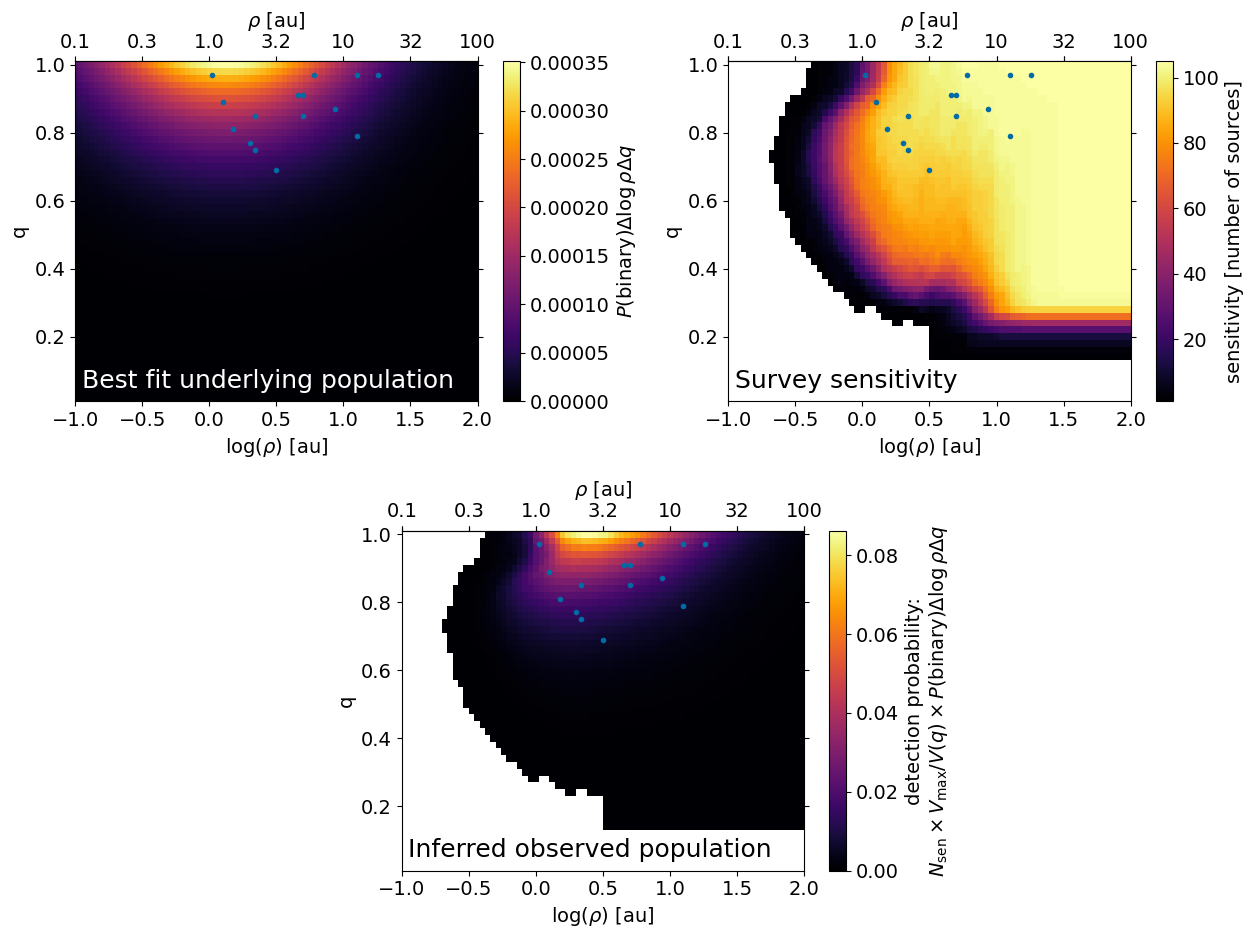

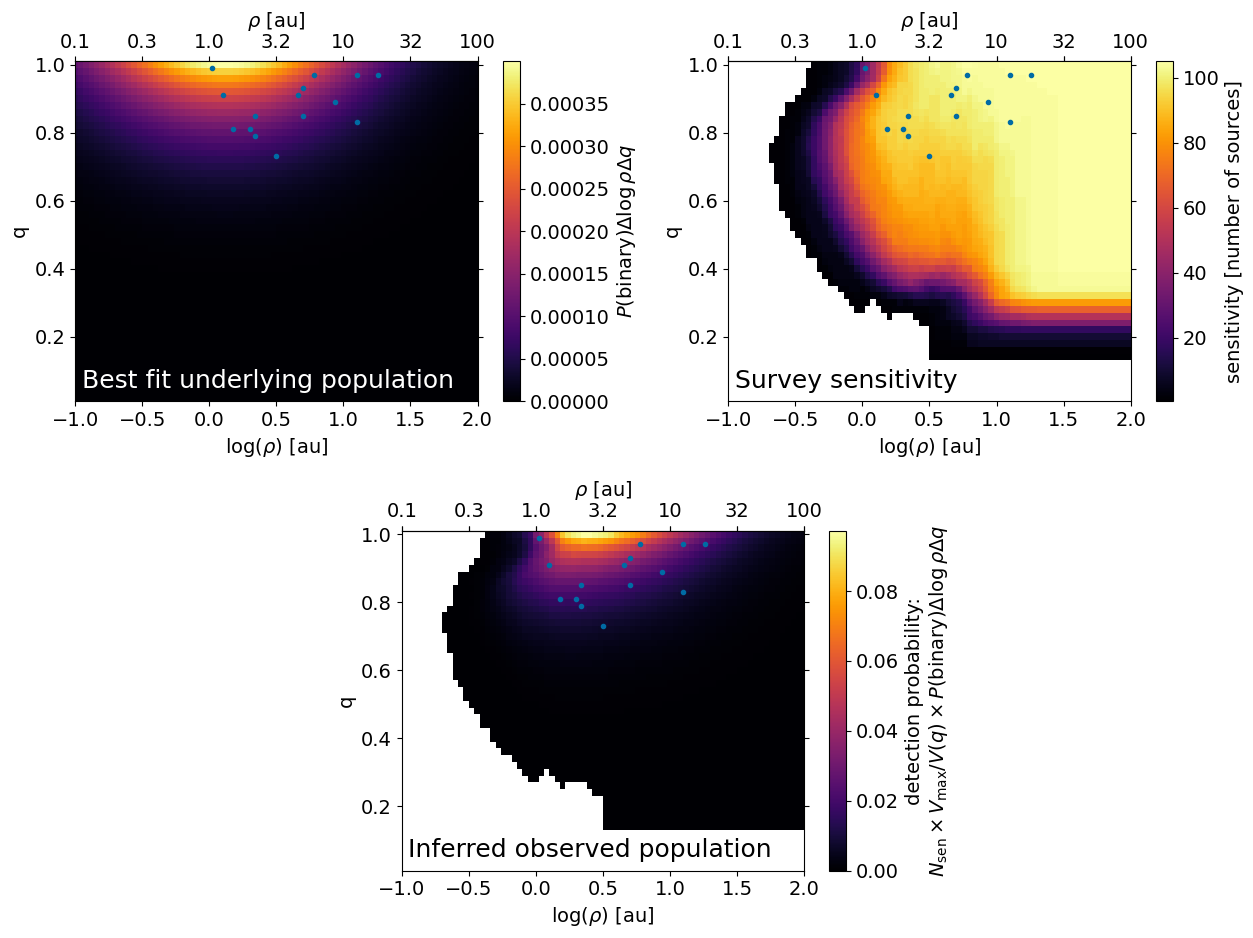

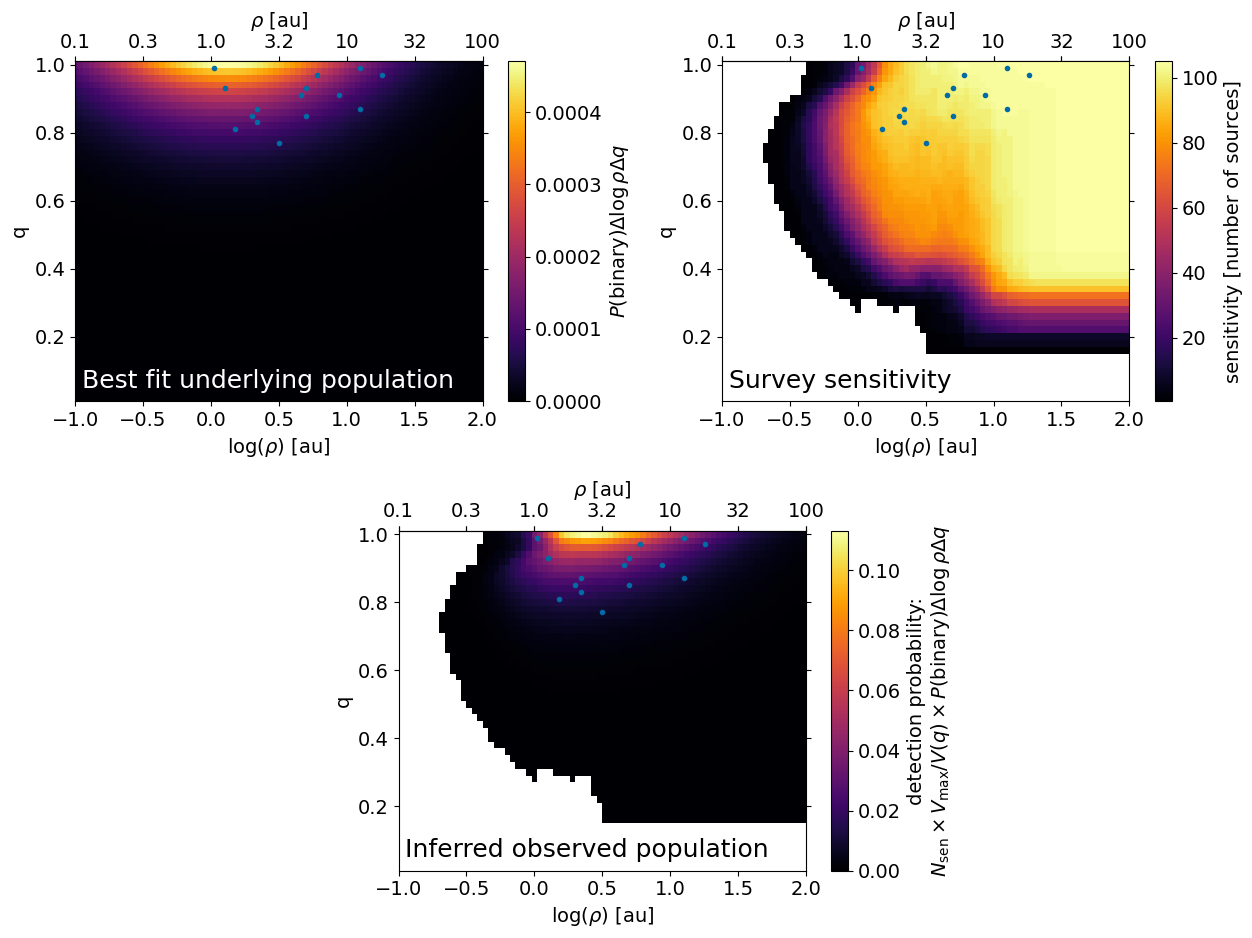

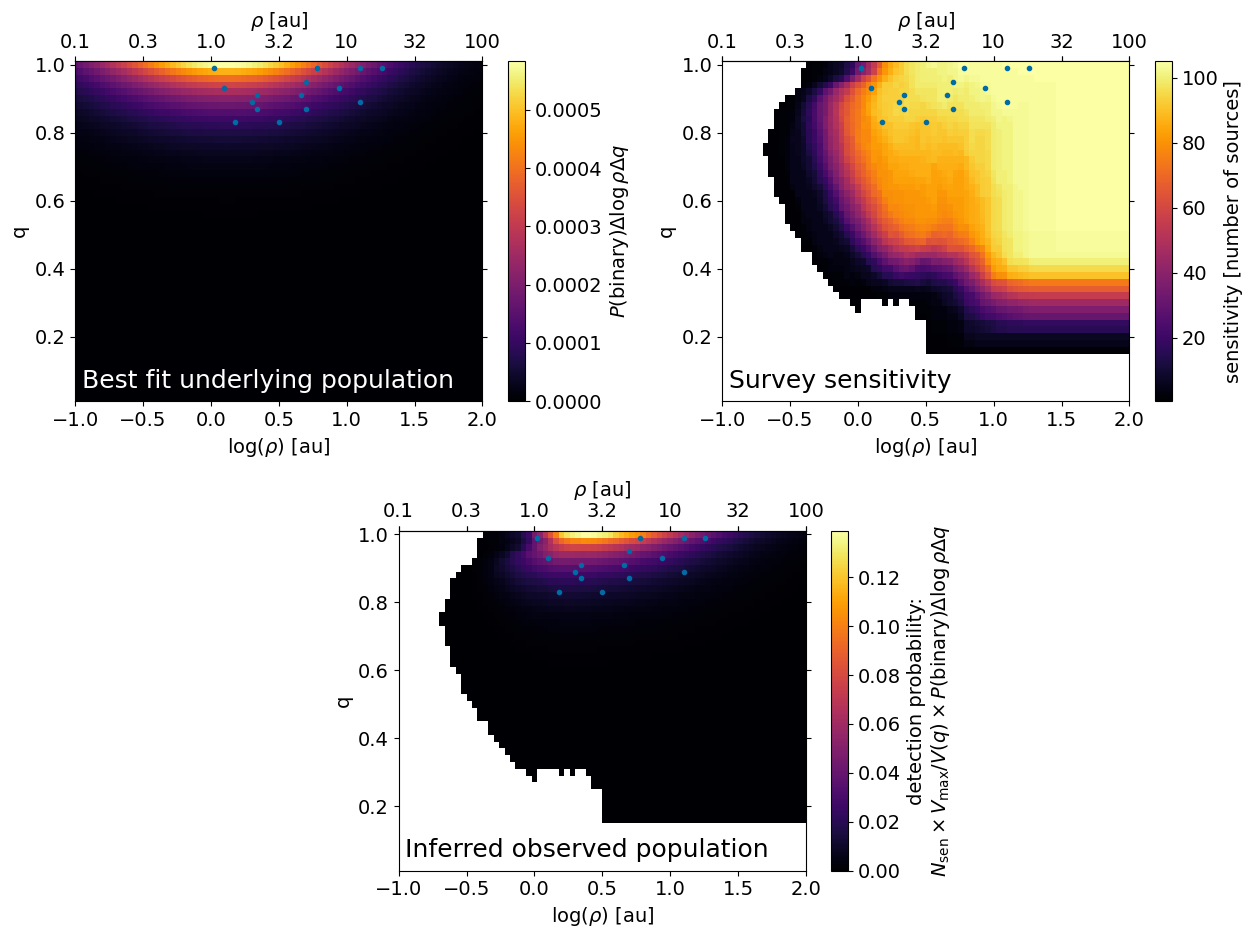

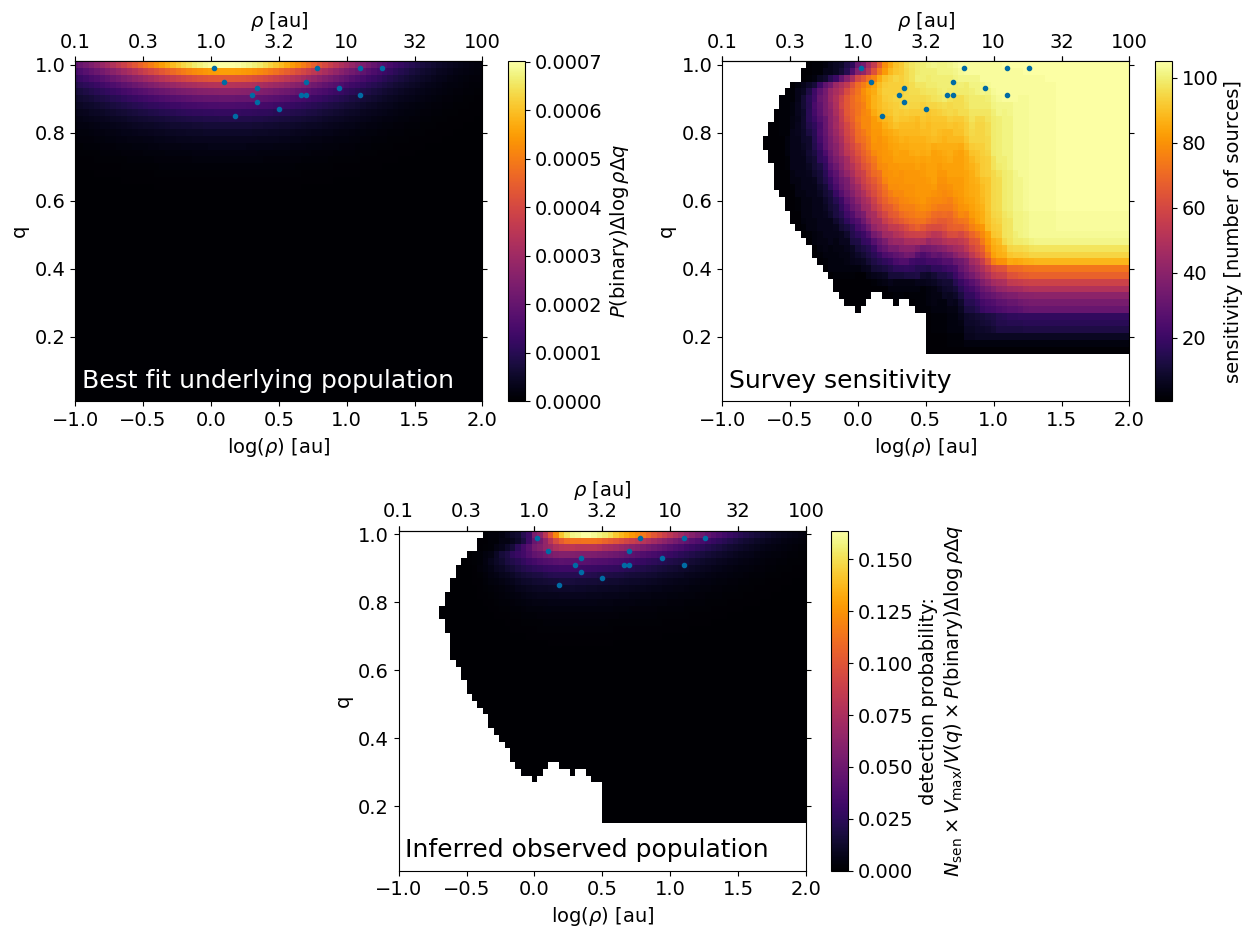

In [38]:
# pltsens = np.copy(sensATMO0p9)
# malmCor = malmCorATMO0p9
# dets = detsATMO0p9
plt.rcParams['font.size']=14


for pltsens,malmCor,dets,ageStr,samp in zip(pltsenss,malmCors,detss,ageStrs,samps):
    pltsens[np.where(pltsens==0)] = np.nan
    F,g,mlp,slp = np.median(samp,axis=0)
    R = ((g+1.)/(slp*np.sqrt(2.*np.pi)))*F*(qqs**g)*np.exp(-1.*((lpps-mlp)**2)/(2*slp**2))*dqs*dlps

    # gs =gridspec.GridSpec(2,4)
    # axs = [plt.subplot(gs[0,:2]),plt.subplot(gs[1,1:3]),plt.subplot(gs[0,2:])]
    # fig,ax = plt.subplots(figsize=(12.8,9.6))
    fig = plt.figure(figsize=(12.8,9.6))
    axs = [plt.subplot2grid((2,4),(0,0),colspan=2),plt.subplot2grid((2,4),(1,1),colspan=2),plt.subplot2grid((2,4),(0,2),colspan=2)]

    # fig,axs=plt.subplots(3,1,sharex='all',figsize=(6,10))
    #fig.subplots_adjust(hspace)
    #cax=plt.pcolormesh(logps,qs,sensATMO2p4/np.max(sensATMO2p4),cmap='inferno')
    cax=axs[0].pcolormesh(minlogps,maxqs, R,rasterized=True,cmap='inferno')
    fig.colorbar(cax,ax=axs[0],label = r"$P( \mathrm{binary} ) \Delta \log \rho \Delta q$")
    axs[0].plot(logps[np.where(dets)[1]],qs[np.where(dets)[0]],'C0.')
    # cax2=axs[0].scatter(np.append(logps[np.where(dets)[1]],[-2,-2]),np.append(qs[np.where(dets)[0]],[0,0]),marker='.',c=np.append(dets[np.where(dets)],[0.,1.]),cmap='Blues')
    #plt.plot(logps[np.where(sens==0)[1]],qs[np.where(sens==0)[0]],'C1.')
    axs[0].set_xlabel(r'$\log(\rho)$ [au]')
    axs[0].set_ylabel('q')
    axs[0].set_xlim(-1,2.0)
    # axs[0].set_ylim(0.,1)
    axs[0].yaxis.set_tick_params(right='on')
    axup = axs[0].secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
    axup.set_xlabel(r"$\rho$ [au]")
    axup.set_xticks(np.logspace(-1,2,7))
    #axup.set_xticks([0.1,0.3,0.7,1,3,7,10,30,70,100])
    axup.set_xticklabels(['0.1','0.3','1.0','3.2','10','32','100'])
    axs[0].text(-0.95,0.05,"Best fit underlying population",color='w',fontsize=18)


    cax=axs[1].pcolormesh(minlogps,maxqs, R*pltsens*malmCor[:,None],rasterized=True,cmap='inferno')#plt.get_cmap('inferno', 10))
    fig.colorbar(cax,ax=axs[1],label = "detection probability:\n"+r"$N_\mathrm{sen} \times V_\mathrm{max}/V(q) \times P( \mathrm{binary} ) \Delta \log \rho \Delta q$")
    axs[1].plot(logps[np.where(dets)[1]],qs[np.where(dets)[0]],'C0.')
    # cax2=axs[1].scatter(np.append(logps[np.where(dets)[1]],[-2,-2]),np.append(qs[np.where(dets)[0]],[0,0]),marker='.',c=np.append(dets[np.where(dets)],[0.,1.]),cmap='Blues')
    #plt.plot(logps[np.where(sens==0)[1]],qs[np.where(sens==0)[0]],'C1.')
    axs[1].set_xlabel(r'$\log(\rho)$ [au]')
    axs[1].set_ylabel('q')
    axs[1].set_xlim(-1,2.0)
    axs[1].xaxis.set_tick_params(top='on')
    axs[1].yaxis.set_tick_params(right='on')
    axup = axs[1].secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
    axup.set_xlabel(r"$\rho$ [au]")
    axup.set_xticks(np.logspace(-1,2,7))
    #axup.set_xticks([0.1,0.3,0.7,1,3,7,10,30,70,100])
    axup.set_xticklabels(['0.1','0.3','1.0','3.2','10','32','100'])
    axs[1].text(-0.95,0.05,"Inferred observed population",color='k',fontsize=18)


    cax=axs[2].pcolormesh(minlogps,maxqs, pltsens,rasterized=True,cmap='inferno')
    fig.colorbar(cax,ax=axs[2],label="sensitivity [number of sources]")
    axs[2].plot(logps[np.where(dets)[1]],qs[np.where(dets)[0]],'C0.')
    # cax2=axs[2].scatter(np.append(logps[np.where(dets)[1]],[-2,-2]),np.append(qs[np.where(dets)[0]],[0,0]),marker='.',c=np.append(dets[np.where(dets)],[0.,1.]),cmap='Blues')
    #plt.plot(logps[np.where(sens==0)[1]],qs[np.where(sens==0)[0]],'C1.')
    axs[2].set_xlabel(r'$\log(\rho)$ [au]')
    axs[2].set_ylabel('q')
    axs[2].set_xlim(-1,2.0)
    axs[2].xaxis.set_tick_params(top='on')
    axs[2].yaxis.set_tick_params(right='on')
    axup = axs[2].secondary_xaxis('top', functions=(lambda x: 10**x, lambda x: np.log10(x)))
    axup.set_xlabel(r"$\rho$ [au]")
    axup.set_xticks(np.logspace(-1,2,7))
    #axup.set_xticks([0.1,0.3,0.7,1,3,7,10,30,70,100])
    axup.set_xticklabels(['0.1','0.3','1.0','3.2','10','32','100'])
    axs[2].text(-0.95,0.05,"Survey sensitivity",color='k',fontsize=18)

    # fig.colorbar(cax2,ax=axs[2],label='malmquist weighted detections')

    fig.tight_layout()
    plt.savefig('figs/2DpopMalm'+ageStr+'.pdf',bbox_inches='tight')